# Summary

Create the `elaspic_training_interface` database and fill it with **interface** training data.

Depends on `interface_load_data`.


**TODO** : Make sure that the engine used is InnoDB

----

# Imports

In [1]:
%run imports.ipynb

2016-08-09 15:02:37.440576


In [2]:
NOTEBOOK_NAME = 'elaspic_training_interface'
os.makedirs(NOTEBOOK_NAME, exist_ok=True)

os.environ['NOTEBOOK_NAME'] = NOTEBOOK_NAME
os.environ['DB_PORT'] = '8309'

In [3]:
%run mysqld.ipynb

2016-08-09 15:02:37,938 - root - INFO - MySQL database already running...


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-08-09 15:02:37.926784


In [4]:
db_remote = datapkg.MySQL(
    connection_string=os.environ['DATAPKG_CONNECTION_STR'], 
    shared_folder=os.environ['NOTEBOOK_NAME'], 
    storage_host=None, 
    echo=False, 
    db_engine='InnoDB'
)

In [5]:
elaspic.conf.read_configuration_file(DATABASE={'connection_string': db.connection_string})

In [6]:
import elaspic.elaspic_database_tables

In [7]:
PDB_DIR = '/home/kimlab1/database_data/pdb/data/data/structures/all/pdb'

In [8]:
# Reload logging after elaspic screws it up
%run imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-08-09 15:02:39.568621


In [9]:
logger.setLevel(logging.DEBUG)

In [10]:
logger.debug('xx')

2016-08-09 15:02:39,882 - root - DEBUG - xx


# Load data

In [11]:
DATASETS = ['skempi', 'taipale_ppi', 'taipale_gpca']

DATA = {}
for dataset in DATASETS:
    DATA[dataset] = pd.read_sql_table(dataset, db_remote.engine, schema='protein_interaction_energy')

In [12]:
display(DATA['skempi'].head(2))
print(DATA['skempi'].shape[0])

,id,uniprot_id,partner_uniprot_id,uniprot_mutation,pdb_id,pdb_chain,partner_pdb_chain,pdb_mutation,pfam_id,pfam_clan,ddg_exp
0,1,A0NA69,P01820,D71A,1dvf,D,B,D52A,None,None,1.682290
1,2,A0NA69,P01820,K49A,1dvf,D,B,K30A,None,None,1.003517


2213


In [13]:
for dataset in DATASETS:
    print(dataset); sys.stdout.flush()
    print2(
        "Number of rows:",
        "{:20,d}".format(DATA[dataset].shape[0]))
    print2(
        "Number of unique rows:",
        "{:20,d}".format(DATA[dataset].drop_duplicates().shape[0]))
    print2(
        "Number of null mutations:",
        "{:20,d}".format(DATA[dataset]['uniprot_mutation'].isnull().sum()))
    print2(
        "Number of unique mutations:",
        "{:20,d}".format(
            DATA[dataset][['uniprot_id', 'partner_uniprot_id', 'uniprot_mutation']]
            .drop_duplicates().shape[0]))

skempi
Number of rows:                                                            2,213
Number of unique rows:                                                     2,213
Number of null mutations:                                                      0
Number of unique mutations:                                                2,213
taipale_ppi
Number of rows:                                                            2,348
Number of unique rows:                                                     2,348
Number of null mutations:                                                      0
Number of unique mutations:                                                2,348
taipale_gpca
Number of rows:                                                              742
Number of unique rows:                                                       742
Number of null mutations:                                                      0
Number of unique mutations:                                                  

# === Creating the database ===

Can skim this step f you have done it already...

In [14]:
# Collect uniprot_ids for all datasets
sql_query_template = """\
SELECT uniprot_id 
from protein_interaction_energy.{0}
UNION
SELECT partner_uniprot_id uniprot_id
from protein_interaction_energy.{0}
"""

uniprot_ids = set()
for dataset in DATASETS:
    print(dataset, end=': ')
    uniprot_ids |= set(pd.read_sql_query(sql_query_template.format(dataset), db.engine)['uniprot_id'])
    print(len(uniprot_ids))
uniprot_ids = sorted(uniprot_ids)

skempi: 114
taipale_ppi: 889
taipale_gpca: 889


# Create database

In [784]:
CONNECTION_STRING = (
    kmtools.db_tools.make_connection_string(**{
        **kmtools.db_tools.parse_connection_string(db.connection_string),
        'db_schema': NOTEBOOK_NAME
    }))
print(CONNECTION_STRING)

mysql://root@localhost:8309/elaspic_training_interface?unix_socket=/tmp/strokach/elaspic_training_set/mysql.sock


In [785]:
!elaspic database --connection_string="$CONNECTION_STRING" create --drop_schema

In [787]:
for chunk in pd.read_sql_table('domain', db_remote.engine, schema='elaspic', chunksize=1000):
    chunk.to_sql(
        'domain', db.engine, schema='elaspic_training_interface', if_exists='append', index=False)

In [788]:
for chunk in pd.read_sql_table('domain_contact', db_remote.engine, schema='elaspic', chunksize=1000):
    chunk.to_sql(
        'domain_contact', db.engine, schema='elaspic_training_interface', if_exists='append', index=False)

In [789]:
sql_command = """\
ALTER TABLE {schema_name}.uniprot_domain
MODIFY COLUMN uniprot_domain_id INT NOT NULL AUTO_INCREMENT,
# ADD COLUMN max_seq_identity int,  -- ELASPIC does this already
ADD COLUMN uniprot_domain_id_old int,
ADD INDEX Z (uniprot_domain_id_old);
""".format(schema_name=NOTEBOOK_NAME)

db.engine.execute(sql_command)

In [790]:
sql_command = """\
ALTER TABLE {schema_name}.uniprot_domain_pair
MODIFY COLUMN uniprot_domain_pair_id INT NOT NULL AUTO_INCREMENT,
# ADD COLUMN max_seq_identity INT,  -- ELASPIC does this already
ADD COLUMN uniprot_domain_pair_id_old INT,
ADD INDEX Z (uniprot_domain_pair_id_old);
""".format(schema_name=NOTEBOOK_NAME)

db.engine.execute(sql_command)

# UniProt domains

In [16]:
# Obtain ELASPIC protein domains
sql_query = """\
SELECT * 
FROM elaspic.uniprot_domain
JOIN elaspic.uniprot_domain_template USING (uniprot_domain_id)
LEFT JOIN elaspic.uniprot_domain_model USING (uniprot_domain_id)
WHERE uniprot_id in ('{}')
""".format("', '".join(uniprot_ids))

uniprot_domain_extened = pd.read_sql_query(sql_query, db_remote.engine)

In [17]:
uniprot_domain_extened['max_seq_identity'] = 100.0

## Set path_to_data

In [18]:
uniprot_domain_extened['path_to_data_old'] = uniprot_domain_extened['path_to_data']

In [19]:
ARCHIVE_DIR_OLD = '/home/kimlab1/database_data/elaspic_v2'
ARCHIVE_DIR = op.abspath(op.join(NOTEBOOK_NAME, 'elaspic'))
os.makedirs(ARCHIVE_DIR, exist_ok=True)

In [20]:
def make_path_to_data(path_to_data_old):
    prefix = 'training'
    if pd.isnull(path_to_data_old):
        return np.nan
    path_to_data_old_full = op.abspath(op.join(ARCHIVE_DIR_OLD, path_to_data_old))
    if not op.isdir(path_to_data_old_full) and not path_to_data_old.startswith(prefix):
        print("Path to data is missing: '{}'".format(path_to_data_old))
        return np.nan
    path_to_data_new = prefix + path_to_data_old[path_to_data_old.find('/'):].replace('*', '.')
    return path_to_data_new


assert make_path_to_data('human/B2R/86/B2R862/RING*16-62/') == 'training/B2R/86/B2R862/RING.16-62/'

In [21]:
uniprot_domain_extened['path_to_data'] = uniprot_domain_extened['path_to_data'].apply(make_path_to_data)

Path to data is missing: 'hv1n5/P12/49/P12497/Integrase_Zn.1155-1194/'
Path to data is missing: 'hv1n5/P12/49/P12497/zf-CCHC.391-406/'
Path to data is missing: 'hv1n5/P12/49/P12497/zf-CCHC.412-428/'
Path to data is missing: 'hv1n5/P12/49/P12497/RVP.493-586/'
Path to data is missing: 'hv1n5/P12/49/P12497/RVT_1.650-821/'
Path to data is missing: 'hv1n5/P12/49/P12497/RVT_thumb.825-894/'
Path to data is missing: 'hv1n5/P12/49/P12497/RVT_connect.904-1006/'
Path to data is missing: 'hv1n5/P12/49/P12497/RNase_H.1024-1143/'
Path to data is missing: 'hv1n5/P12/49/P12497/rve.1203-1308/'
Path to data is missing: 'hv1n5/P12/49/P12497/IN_DBD_C.1368-1417/'


In [22]:
uniprot_domain_extened[['path_to_data_old', 'path_to_data']].head()

,path_to_data_old,path_to_data
0,human/B2R/86/B2R862/RING*16-62/,training/B2R/86/B2R862/RING.16-62/
1,human/B3K/NS/B3KNS9/KRAB*22-62/,training/B3K/NS/B3KNS9/KRAB.22-62/
2,human/B3K/VA/B3KVA4/HLH*565-618/,training/B3K/VA/B3KVA4/HLH.565-618/
3,human/B3K/WQ/B3KWQ3/Actin_ATPase*1-253/,training/B3K/WQ/B3KWQ3/Actin_ATPase.1-253/
4,human/B7Z/C3/B7ZC38/SH3*347-397/,training/B7Z/C3/B7ZC38/SH3.347-397/


In [23]:
uniprot_domain_extened['path_to_data'].notnull().sum()

1163

## Copy precalculated files

In [24]:
path_to_data_stubs = sorted({
    (op.dirname(op.dirname(x[0])), op.dirname(op.dirname(x[1])))
    for x in (
        uniprot_domain_extened[['path_to_data_old', 'path_to_data']]
        .dropna()
        .drop_duplicates()
        .values
        .tolist()
    )
})

In [25]:
path_to_data_stubs[0]

('bacam/P00/64/P00648', 'training/P00/64/P00648')

In [26]:
MY_RE = re.compile('.*_[GVALICMFWPDESTYQNKRH]+[1-9]+[0-9]*[GVALICMFWPDESTYQNKRH]+_.*')


def _get_files(path):
    files = [
        f for f in os.listdir(path) 
        if op.isfile(op.join(path, f)) and not MY_RE.findall(f)
    ]
    return files


def _get_folders(path, uniprot_id):
    folders = [
        d for d in os.listdir(path)
        if op.isdir(op.join(path, d)) and not d.startswith(uniprot_id) and not d.endswith('.training')
    ]
    return folders


def copy_path_to_data_stub(path_to_data_old, path_to_data_new):
    uniprot_id = op.basename(path_to_data_old)
    ptd_old = op.abspath(op.join(ARCHIVE_DIR_OLD, path_to_data_old))
    ptd_new = op.abspath(op.join(ARCHIVE_DIR, path_to_data_new))
    # print(uniprot_id)
    # print(ptd_old)
    # print(ptd_new)

    os.makedirs(ptd_new, exist_ok=True)
    for file in _get_files(ptd_old):
        # print(op.relpath(op.join(ptd_new, file), ptd_new))
        shutil.copy2(op.join(ptd_old, file), 
                     op.join(ptd_new, file.replace('*', '.')))

    for folder in _get_folders(ptd_old, uniprot_id):
        ptd_old_folder = op.join(ptd_old, folder)
        ptd_new_folder = op.join(ptd_new, folder)
        os.makedirs(ptd_new_folder.replace('*', '.'), exist_ok=True)
        for file in _get_files(ptd_old_folder):
            # print(op.relpath(op.join(ptd_new_folder, file), ptd_new))
            shutil.copy2(op.join(ptd_old_folder, file), 
                         op.join(ptd_new_folder.replace('*', '.'), file.replace('*', '.')))

copy_path_to_data_stub('bacam/P00/64/P00648', 'training/P00/64/P00648')

# UniProt proteins

In [27]:
# Obtain ELASPIC protein domains
sql_query = """\
SELECT * 
FROM elaspic.uniprot_sequence
LEFT JOIN elaspic.provean USING (uniprot_id)
WHERE uniprot_id in ('{}')
""".format("', '".join(uniprot_ids))

uniprot_extened = pd.read_sql_query(sql_query, db_remote.engine)

In [28]:
uniprot_extened['uniprot_name'] = uniprot_extened['uniprot_id'] + '_training'

## Save to database

# UniProt domain pairs

## Domain templates

`uniprot_domain_sequence` -> `structural_templates`

In [29]:
sql_query = """\
SELECT *
FROM elaspic_training_interface.uniprot_domain
JOIN elaspic_training_interface.uniprot_domain_template USING (uniprot_domain_id)
JOIN elaspic_training_interface.uniprot_sequence USING (uniprot_id)
"""
uniprot_domain_sequence = pd.read_sql_query(sql_query, db.engine)

In [30]:
import elaspic_utils

uniprot_domain_sequence['uniprot_domain_sequence'] = (
    uniprot_domain_sequence[['uniprot_sequence', 'domain_def']]
    .apply(lambda x: elaspic_utils.build_database.get_domain_sequence(*x), axis=1)
)

In [31]:
display(uniprot_domain_sequence.head(2))
print(uniprot_domain_sequence.shape[0])

,uniprot_id,uniprot_domain_id,pdbfam_name,pdbfam_idx,pfam_clan,alignment_def,pfam_names,alignment_subdefs,path_to_data,max_seq_identity,uniprot_domain_id_old,template_errors,cath_id,domain_start,domain_end,domain_def,alignment_identity,alignment_coverage,alignment_score,t_date_modified,db,uniprot_name,protein_name,organism_name,gene_name,protein_existence,sequence_version,uniprot_sequence,uniprot_domain_sequence
0,A0NA69,51959162,V-set,1,V-set,22:117,V-set|1,22:117,None,100,None,None,1aj7H00,20,122,20:122,97.96,100.0,0.980620,2015-09-01 05:12:36,tr,A0NA69_training,VDJ complex (Fragment),Mus musculus,None,1,1,MKCSWVIFFLMAVVTGVNSEVQLQQSGAELVKPGASVKLSCTASGF...,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...
1,A0PJJ9,32391418,G_glu_transpept,1,G_glu_transpept,155:590,G_glu_transpept|1,155:590,training/A0P/JJ/A0PJJ9/G_glu_transpept.155-590/,100,None,None,2e0wA00,134,592,134:592,32.99,100.0,0.363405,2015-09-01 05:12:36,tr,A0PJJ9_training,GGT7 protein (Fragment),Homo sapiens,GGT7,2,1,MAAENEASQESALGAYSPVDYMSITSFPRLPEDEPAPAAPLRGRKD...,PQIFQQGAVVTDAARCTSLGIEVLSKQGSSVDAAVAAALCLGIVAP...


1260


### BLAST for PDB templates

In [32]:
# Run BLAST to find templates for all domains (mutant and partner)
import concurrent.futures

SHARED_COLUMNS = ['uniprot_id', 'uniprot_domain_id', 'uniprot_sequence', 'uniprot_domain_sequence']
DATAPKG_DIR = op.dirname(op.dirname(op.dirname(op.abspath(NOTEBOOK_NAME))))
BLAST_DB = op.abspath(op.join(DATAPKG_DIR, 'profs', 'output', 'libraries_all_together_db', 'libraries_all'))
# BLAST_DB = op.abspath(op.join(DATAPKG_DIR, 'profs', 'output', 'libraries', 'libraries'))
# BLAST_DB = op.abspath('/home/kimlab1/database_data/blast/db/pdbaa')
print(BLAST_DB)

blastp = functools.lru_cache(maxsize=1024, typed=False)(kmtools.sequence_tools.blastp)

def worker(x):
    i, row = x
    results_df = blastp(
        sequence=row['uniprot_domain_sequence'], db=BLAST_DB, evalue=0.001, max_target_seqs=100000)
    results_df = local.annotate_blast_results(
        results_df, 
        domain_start=int(row['domain_def'].split(':')[0]), 
        domain_sequence_length=len(row['uniprot_domain_sequence']))
    for column in SHARED_COLUMNS:
        results_df[column] = row[column]
    return results_df

tmp = worker([0, uniprot_domain_sequence.iloc[0]])
display(tmp.head(2))

2016-08-09 15:02:47,160 - kmtools.sequence_tools._blast - DEBUG - blastp -db /home/kimlab1/database_data/biodb/recipes/profs/output/libraries_all_together_db/libraries_all -outfmt '6 qacc sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore qseq sseq' -evalue 0.001 -max_target_seqs 100000


/home/kimlab1/database_data/biodb/recipes/profs/output/libraries_all_together_db/libraries_all


,query_id,subject_id,pc_identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,qseq,sseq,a2b,b2a,pdb_id,pdb_chain,pdb_pdbfam_name,pdb_pdbfam_idx,pdb_pfam_clan,pdb_domain_def,pdb_cath_id,alignment_identity,alignment_coverage,alignment_score,domain_start_new,domain_end_new,domain_def_new,t_date_modified,uniprot_id,uniprot_domain_id,uniprot_sequence,uniprot_domain_sequence
0,unnamed,2rcs_H|V-set|1|Ig|1:113|2rcsH00,97.96,98,2,0,1,98,1,98,1.000000e-67,202.0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,QVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",2rcs,H,V-set,1,Ig,1:113,2rcsH00,97.96,95.145631,0.933017,20,117,20:117,2016-08-09 15:02:53.252323,A0NA69,51959162,MKCSWVIFFLMAVVTGVNSEVQLQQSGAELVKPGASVKLSCTASGF...,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...
1,unnamed,2rcs_H|V-set+C1-set|1|Ig|1:213|2rcsH02,97.96,98,2,0,1,98,1,98,1.000000e-66,204.0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,QVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",2rcs,H,V-set+C1-set,1,Ig,1:213,2rcsH02,97.96,95.145631,0.933017,20,117,20:117,2016-08-09 15:02:53.252323,A0NA69,51959162,MKCSWVIFFLMAVVTGVNSEVQLQQSGAELVKPGASVKLSCTASGF...,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...


In [33]:
tmp.tail()

,query_id,subject_id,pc_identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,qseq,sseq,a2b,b2a,pdb_id,pdb_chain,pdb_pdbfam_name,pdb_pdbfam_idx,pdb_pfam_clan,pdb_domain_def,pdb_cath_id,alignment_identity,alignment_coverage,alignment_score,domain_start_new,domain_end_new,domain_def_new,t_date_modified,uniprot_id,uniprot_domain_id,uniprot_sequence,uniprot_domain_sequence
3097,unnamed,4a6y_A|V-set+C1-set|1|Ig|1:211|4a6yA02,28.12,96,59,4,4,97,4,91,0.001,37.7,LQQSGAELVKPGASVKLSCTAS-GFNIKDTYMHWVKQRPEQGLEWI...,VTQESALTTSPGETVTLTCRSSTGAVTTSNYANWVQEKPDHLF--T...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",4a6y,A,V-set+C1-set,1,Ig,1:211,4a6yA02,28.12,91.262136,0.289429,23,116,23:116,2016-08-09 15:02:53.252323,A0NA69,51959162,MKCSWVIFFLMAVVTGVNSEVQLQQSGAELVKPGASVKLSCTASGF...,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...
3098,unnamed,1yuh_L|V-set+C1-set|1|Ig|2:210|1yuhL02,28.12,96,59,4,4,97,3,90,0.001,37.7,LQQSGAELVKPGASVKLSCTAS-GFNIKDTYMHWVKQRPEQGLEWI...,VTQESALTTSPGETVTLTCRSSTGAVTTSNYANWVQEKPDR--LFT...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1yuh,L,V-set+C1-set,1,Ig,2:210,1yuhL02,28.12,91.262136,0.289429,23,116,23:116,2016-08-09 15:02:53.252323,A0NA69,51959162,MKCSWVIFFLMAVVTGVNSEVQLQQSGAELVKPGASVKLSCTASGF...,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...
3099,unnamed,3qeh_H|V-set|1|Ig|2:106|3qehH00,29.35,92,47,4,12,96,12,92,0.001,36.6,VKPGASVKLSCTAS-------GFNIKDTYMHWVKQRPEQGLEWIGR...,VTPGEAASISCRSSQSLLHTNGFQ----YLDWYLQKPGQSPQLLIY...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,,,,,,,,15,16,...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,22,23,24,,,,,...",3qeh,H,V-set,1,Ig,2:106,3qehH00,29.35,82.524272,0.271360,31,115,31:115,2016-08-09 15:02:53.252323,A0NA69,51959162,MKCSWVIFFLMAVVTGVNSEVQLQQSGAELVKPGASVKLSCTASGF...,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...
3100,unnamed,1rjl_A|V-set|1|Ig|1:108|1rjlA00,29.90,97,58,5,1,96,1,88,0.001,36.2,EVQLQQSGAEL-VKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGL...,DIQMNQSPSSLSASLGDTITITCHASQ-NI-NVWLNWFQQKPGSIP...,"1,2,3,4,5,6,7,8,9,10,11,,12,13,14,15,16,17,18,...","1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,2...",1rjl,A,V-set,1,Ig,1:108,1rjlA00,29.90,93.203883,0.311348,20,115,20:115,2016-08-09 15:02:53.252323,A0NA69,51959162,MKCSWVIFFLMAVVTGVNSEVQLQQSGAELVKPGASVKLSCTASGF...,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...
3101,unnamed,3s36_L|V-set+C1-set|1|V-set+C1-set|1:214|3s36L02,29.90,97,58,4,1,96,1,88,0.001,37.7,EVQLQQSGAEL-VKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGL...,DIQMTQSPSSVSASIGDRVTITCRAS--QGIDNWLGWYQQKPGKAP...,"1,2,3,4,5,6,7,8,9,10,11,,12,13,14,15,16,17,18,...","1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,2...",3s36,L,V-set+C1-set,1,V-set+C1-set,1:214,3s36L02,29.90,93.203883,0.311348,20,115,20:115,2016-08-09 15:02:53.252323,A0NA69,51959162,MKCSWVIFFLMAVVTGVNSEVQLQQSGAELVKPGASVKLSCTASGF...,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...


In [34]:
print(tmp.loc[3097, 'qseq'])
print(tmp.loc[3097, 'sseq'])

LQQSGAELVKPGASVKLSCTAS-GFNIKDTYMHWVKQRPEQGLEWIGRIDPANGNTKYDP-KFQGKATITADTSSNTAYLQLSSLTSEDTAVYYCA
VTQESALTTSPGETVTLTCRSSTGAVTTSNYANWVQEKPDHLF--TGLIGGTNNRAPGVPARFSGSLI------GDKAALTITGAQTEDEAIYFCA


In [35]:
logging.getLogger('kmtools.sequence_tools').setLevel(logging.DEBUG)

In [36]:
structural_templates_file = op.join(NOTEBOOK_NAME, 'structural_templates.pkl')
if not op.isfile(structural_templates_file):
    with concurrent.futures.ProcessPoolExecutor() as p:
        results_df_all = list(p.map(worker, uniprot_domain_sequence.iterrows()))
        with open(op.join(NOTEBOOK_NAME, 'results_df_all.pkl'), 'wb') as ofh:
            pickle.dump(results_df_all, ofh)
        structural_templates = pd.concat(results_df_all, ignore_index=True)
        structural_templates.to_pickle(structural_templates_file)
else:
    logger.info('Loading from file...')
    with open(op.join(NOTEBOOK_NAME, 'results_df_all.pkl'), 'rb') as ifh:
        results_df_all = pickle.load(ifh)
    structural_templates = pd.read_pickle(structural_templates_file)

2016-08-09 15:02:54,016 - root - INFO - Loading from file...


In [37]:
display(structural_templates.head())
print(structural_templates.shape)

,alignment_coverage,alignment_identity,alignment_length,alignment_score,bitscore,domain_def_new,domain_end_new,domain_start_new,evalue,gap_opens,mismatches,pc_identity,pdb_cath_id,pdb_chain,pdb_domain_def,pdb_id,pdb_pdbfam_idx,pdb_pdbfam_name,pdb_pfam_clan,q_end,q_start,qseq,query_id,s_end,s_start,sseq,subject_id,t_date_modified,uniprot_domain_id,uniprot_domain_sequence,uniprot_id,uniprot_sequence
0,88.311688,39.71,68.0,0.377307,59.3,10:77,77.0,10.0,2.000000e-12,1.0,38.0,39.71,2ecvA00,A,1:85,2ecv,1.0,zf-C3HC4_4,RING,77.0,10.0,MMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKNPSQKQLRQE...,unnamed,80.0,16.0,VKEEVTCPICLELLTQPLSLDCGHSFCQACLT---ANHKKSMLDKG...,2ecv_A|zf-C3HC4_4|1|RING|1:85|2ecvA00,2016-08-02 10:43:11.905879,3288098,MASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKN...,B2R862,MASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKN...
1,98.701299,36.84,76.0,0.394785,55.5,2:77,77.0,2.0,6.000000e-11,1.0,46.0,36.84,2egpA00,A,1:79,2egp,1.0,zf-C3HC4_4,RING,77.0,2.0,ASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKNP...,unnamed,74.0,1.0,GSSGSSGNVQEEVTCPICLELLTEPLSLDCGHSLCRACITVSNKEA...,2egp_A|zf-C3HC4_4|1|RING|1:79|2egpA00,2016-08-02 10:43:11.905879,3288098,MASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKN...,B2R862,MASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKN...
2,84.415584,40.00,65.0,0.362987,54.7,10:74,74.0,10.0,1.000000e-10,1.0,36.0,40.00,2ecwA00,A,1:85,2ecw,1.0,zf-C3HC4_4,RING,74.0,10.0,MMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKNPSQKQLRQE...,unnamed,77.0,16.0,IKEEVTCPICLELLKEPVSADCNHSFCRACITLNYESNRNTDGKGN...,2ecw_A|zf-C3HC4_4|1|RING|1:85|2ecwA00,2016-08-02 10:43:11.905879,3288098,MASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKN...,B2R862,MASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKN...
3,79.220779,34.43,61.0,0.298730,47.4,2:62,62.0,2.0,4.000000e-08,1.0,34.0,34.43,2ecjA00,A,1:58,2ecj,1.0,zf-C3HC4_4,RING,62.0,2.0,ASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKNP...,unnamed,58.0,4.0,GSSGALENLQVEASCSVCLEYLKEPVIIECGHNFCKACITRWWED-...,2ecj_A|zf-C3HC4_4|1|RING|1:58|2ecjA00,2016-08-02 10:43:11.905879,3288098,MASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKN...,B2R862,MASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKN...
4,85.714286,33.33,66.0,0.314259,45.8,7:72,72.0,7.0,2.000000e-07,1.0,38.0,33.33,2yslA00,A,1:73,2ysl,1.0,zf-C3HC4_4,RING,72.0,7.0,TKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKNPSQKQL...,unnamed,73.0,14.0,VNKLQEEVICPICLDILQKPVTIDCGHNFCLKCITQIGETSCG---...,2ysl_A|zf-C3HC4_4|1|RING|1:73|2yslA00,2016-08-02 10:43:11.905879,3288098,MASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKN...,B2R862,MASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKN...


(177795, 32)


In [38]:
pdbfam_names = set(os.listdir('/home/kimlab1/afgiraldofo/Experimentos/Uniprot5/E_DB_Libraries_nr'))
pprint(set(uniprot_domain_sequence['pdbfam_name']) - pdbfam_names)

{'Ank_2',
 'Arm',
 'BIR',
 'BNR_2',
 'BRCT',
 'Filamin',
 'IBB+Arm',
 'Ion_trans',
 'Kelch_1',
 'LRR_6',
 'MIF4G',
 'NHL',
 'RCC1',
 'TPR_1',
 'WD40',
 'zf-C2H2',
 'zf-H2C2_2+zf-C2H2'}


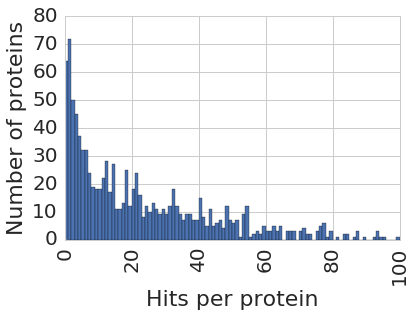

In [39]:
num_hits = [df.shape[0] for df in results_df_all]
plt.hist(num_hits, range=(0, 100), bins=100)
plt.xticks(rotation='vertical')
plt.xlabel("Hits per protein")
plt.ylabel("Number of proteins")

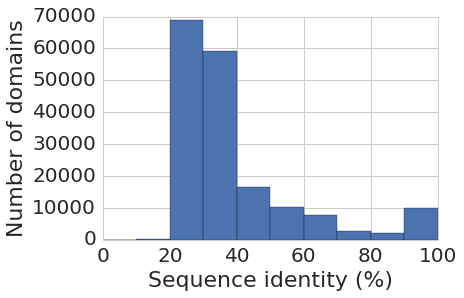

In [40]:
structural_templates['alignment_identity'].hist(range=(0, 100))
plt.xlabel('Sequence identity (%)')
plt.ylabel('Number of domains')

In [41]:
structural_templates_bak = structural_templates.copy()

## Domain pair templates

In [73]:
# Domain templates
structural_templates = structural_templates_bak.copy()

In [74]:
display(structural_templates.head(2))
print(structural_templates.shape[0])
print(structural_templates.drop_duplicates(subset=['uniprot_id', 'uniprot_domain_id']).shape[0])

,alignment_coverage,alignment_identity,alignment_length,alignment_score,bitscore,domain_def_new,domain_end_new,domain_start_new,evalue,gap_opens,mismatches,pc_identity,pdb_cath_id,pdb_chain,pdb_domain_def,pdb_id,pdb_pdbfam_idx,pdb_pdbfam_name,pdb_pfam_clan,q_end,q_start,qseq,query_id,s_end,s_start,sseq,subject_id,t_date_modified,uniprot_domain_id,uniprot_domain_sequence,uniprot_id,uniprot_sequence
0,88.311688,39.71,68.0,0.377307,59.3,10:77,77.0,10.0,2.000000e-12,1.0,38.0,39.71,2ecvA00,A,1:85,2ecv,1.0,zf-C3HC4_4,RING,77.0,10.0,MMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKNPSQKQLRQE...,unnamed,80.0,16.0,VKEEVTCPICLELLTQPLSLDCGHSFCQACLT---ANHKKSMLDKG...,2ecv_A|zf-C3HC4_4|1|RING|1:85|2ecvA00,2016-08-02 10:43:11.905879,3288098,MASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKN...,B2R862,MASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKN...
1,98.701299,36.84,76.0,0.394785,55.5,2:77,77.0,2.0,6.000000e-11,1.0,46.0,36.84,2egpA00,A,1:79,2egp,1.0,zf-C3HC4_4,RING,77.0,2.0,ASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKNP...,unnamed,74.0,1.0,GSSGSSGNVQEEVTCPICLELLTEPLSLDCGHSLCRACITVSNKEA...,2egp_A|zf-C3HC4_4|1|RING|1:79|2egpA00,2016-08-02 10:43:11.905879,3288098,MASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKN...,B2R862,MASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKN...


177795
1196


### a2b / b2a

In [75]:
structural_templates['a2b'], structural_templates['b2a'] = list(zip(*(
    kmtools.sequence_tools.get_crossmapping(alignment_ref, alignment_alt, skip_mismatch=False)
    for alignment_ref, alignment_alt
    in structural_templates[['qseq', 'sseq']].values)))

In [76]:
structural_templates.head(2)

,alignment_coverage,alignment_identity,alignment_length,alignment_score,bitscore,domain_def_new,domain_end_new,domain_start_new,evalue,gap_opens,mismatches,pc_identity,pdb_cath_id,pdb_chain,pdb_domain_def,pdb_id,pdb_pdbfam_idx,pdb_pdbfam_name,pdb_pfam_clan,q_end,q_start,qseq,query_id,s_end,s_start,sseq,subject_id,t_date_modified,uniprot_domain_id,uniprot_domain_sequence,uniprot_id,uniprot_sequence,a2b,b2a
0,88.311688,39.71,68.0,0.377307,59.3,10:77,77.0,10.0,2.000000e-12,1.0,38.0,39.71,2ecvA00,A,1:85,2ecv,1.0,zf-C3HC4_4,RING,77.0,10.0,MMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKNPSQKQLRQE...,unnamed,80.0,16.0,VKEEVTCPICLELLTQPLSLDCGHSFCQACLT---ANHKKSMLDKG...,2ecv_A|zf-C3HC4_4|1|RING|1:85|2ecvA00,2016-08-02 10:43:11.905879,3288098,MASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKN...,B2R862,MASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKN...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
1,98.701299,36.84,76.0,0.394785,55.5,2:77,77.0,2.0,6.000000e-11,1.0,46.0,36.84,2egpA00,A,1:79,2egp,1.0,zf-C3HC4_4,RING,77.0,2.0,ASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKNP...,unnamed,74.0,1.0,GSSGSSGNVQEEVTCPICLELLTEPLSLDCGHSLCRACITVSNKEA...,2egp_A|zf-C3HC4_4|1|RING|1:79|2egpA00,2016-08-02 10:43:11.905879,3288098,MASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKN...,B2R862,MASTTSTKKMMEEATCSICLSLMTNPVSINCGHSYCHLCITDFFKN...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."


### uniprot_pairs

In [77]:
# Protein pairs
uniprot_pairs = []
for dataset in DATASETS:
    uniprot_pairs.append(DATA[dataset][['uniprot_id', 'partner_uniprot_id']])
uniprot_pairs = pd.concat(uniprot_pairs).drop_duplicates()

In [45]:
display(uniprot_pairs.head())
print(uniprot_pairs.shape[0])

,uniprot_id,partner_uniprot_id
0,A0NA69,P01820
3,P00044,P00431
6,P00431,P00004
12,P00431,P00044
15,P00648,P11540


999


In [46]:
# All uniprot pairs from training set
print2("Rows:", uniprot_pairs.shape[0])
print2("Protein pairs:", uniprot_pairs.drop_duplicates(['uniprot_id', 'partner_uniprot_id']).shape[0])

Rows:                                                       999
Protein pairs:                                              999


### uniprot_pairs_wtemplates

In [725]:
uniprot_pairs_wtemplates = (
    uniprot_pairs
    .merge(
        structural_templates,
        on=['uniprot_id'])
    .merge(
        structural_templates.rename(columns={'uniprot_id': 'partner_uniprot_id'}),
        on=['partner_uniprot_id'],
        suffixes=('_1', '_2'))
)

In [726]:
# Pairs where each protein has at least one domain with a template
print2("Rows:", uniprot_pairs_wtemplates.shape[0])
print2("Protein pairs:", uniprot_pairs_wtemplates.drop_duplicates(
        ['uniprot_id', 'partner_uniprot_id']).shape[0])  # 649
print2("Protein domain pairs:", uniprot_pairs_wtemplates.drop_duplicates(
        ['uniprot_id', 'partner_uniprot_id', 'uniprot_domain_id_1', 'uniprot_domain_id_2']).shape[0])
print2("Domain pairs:", uniprot_pairs_wtemplates.drop_duplicates(
        ['uniprot_domain_id_1', 'uniprot_domain_id_2']).shape[0])

Rows:                                                       65384472
Protein pairs:                                              649
Protein domain pairs:                                       1752
Domain pairs:                                               1752


### Alignment props

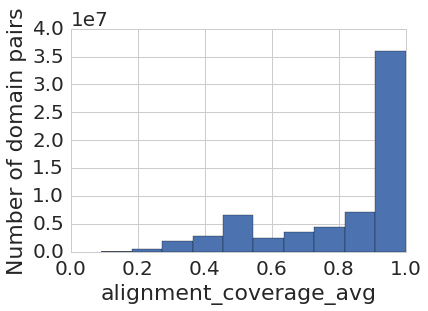

In [727]:
uniprot_pairs_wtemplates['alignment_coverage_avg'] = np.sqrt(
    (uniprot_pairs_wtemplates['alignment_coverage_1'] / 100) *
    (uniprot_pairs_wtemplates['alignment_coverage_2'] / 100))
uniprot_pairs_wtemplates['alignment_coverage_avg'].hist()
plt.xlabel('alignment_coverage_avg')
plt.ylabel('Number of domain pairs')

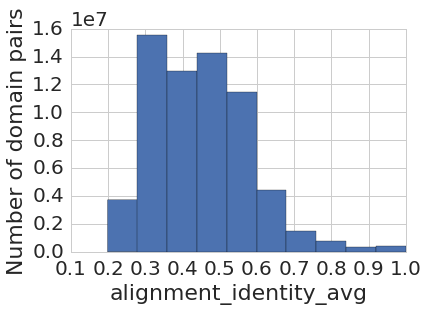

In [728]:
uniprot_pairs_wtemplates['alignment_identity_avg'] = np.sqrt(
    (uniprot_pairs_wtemplates['alignment_identity_1'] / 100) *
    (uniprot_pairs_wtemplates['alignment_identity_2'] / 100))
uniprot_pairs_wtemplates['alignment_identity_avg'].hist()
plt.xlabel('alignment_identity_avg')
plt.ylabel('Number of domain pairs')

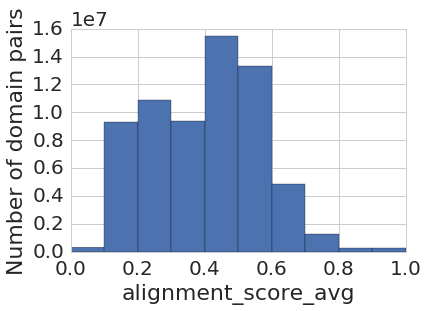

In [729]:
uniprot_pairs_wtemplates['alignment_score_avg'] = np.sqrt(
    (uniprot_pairs_wtemplates['alignment_score_1']) *
    (uniprot_pairs_wtemplates['alignment_score_2']))
uniprot_pairs_wtemplates['alignment_score_avg'].hist(range=(0, 1))
plt.xlabel('alignment_score_avg')
plt.ylabel('Number of domain pairs')

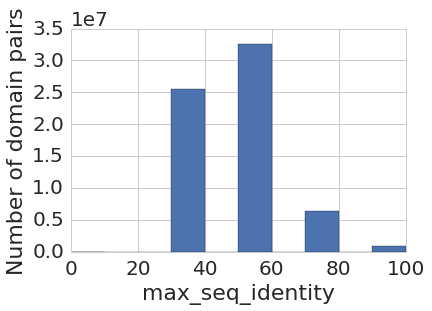

In [766]:
uniprot_pairs_wtemplates['max_seq_identity'] = (
    uniprot_pairs_wtemplates['alignment_identity_avg'].apply(local.get_max_seq_identity)
)
(uniprot_pairs_wtemplates['max_seq_identity'] - 1).hist(range=(0, 100), bins=10)
plt.xlabel('max_seq_identity')
plt.ylabel('Number of domain pairs')

### uniprot_pairs_samepdb

In [730]:
uniprot_pairs_samepdb = (
    uniprot_pairs_wtemplates[
        (uniprot_pairs_wtemplates['pdb_id_1'] == uniprot_pairs_wtemplates['pdb_id_2']) &
        (uniprot_pairs_wtemplates['pdb_chain_1'] != uniprot_pairs_wtemplates['pdb_chain_2'])
    ]
)

In [731]:
print2("Rows:", uniprot_pairs_samepdb.shape[0])
print2("Protein pairs:", uniprot_pairs_samepdb.drop_duplicates(
        ['uniprot_id', 'partner_uniprot_id']).shape[0])  # 191
print2("Protein domain pairs:", uniprot_pairs_samepdb.drop_duplicates(
        ['uniprot_id', 'partner_uniprot_id', 'uniprot_domain_id_1', 'uniprot_domain_id_2']).shape[0])
print2("Domain pairs:", uniprot_pairs_samepdb.drop_duplicates(
        ['uniprot_domain_id_1', 'uniprot_domain_id_2']).shape[0])

Rows:                                                       32654
Protein pairs:                                              191
Protein domain pairs:                                       278
Domain pairs:                                               278


In [732]:
uniprot_pairs_samepdb.head(2)

,uniprot_id,partner_uniprot_id,alignment_coverage_1,alignment_identity_1,alignment_length_1,alignment_score_1,bitscore_1,domain_def_new_1,domain_end_new_1,domain_start_new_1,evalue_1,gap_opens_1,mismatches_1,pc_identity_1,pdb_cath_id_1,pdb_chain_1,pdb_domain_def_1,pdb_id_1,pdb_pdbfam_idx_1,pdb_pdbfam_name_1,pdb_pfam_clan_1,q_end_1,q_start_1,qseq_1,query_id_1,s_end_1,s_start_1,sseq_1,subject_id_1,t_date_modified_1,uniprot_domain_id_1,uniprot_domain_sequence_1,uniprot_sequence_1,a2b_1,b2a_1,alignment_coverage_2,alignment_identity_2,alignment_length_2,alignment_score_2,bitscore_2,domain_def_new_2,domain_end_new_2,domain_start_new_2,evalue_2,gap_opens_2,mismatches_2,pc_identity_2,pdb_cath_id_2,pdb_chain_2,pdb_domain_def_2,pdb_id_2,pdb_pdbfam_idx_2,pdb_pdbfam_name_2,pdb_pfam_clan_2,q_end_2,q_start_2,qseq_2,query_id_2,s_end_2,s_start_2,sseq_2,subject_id_2,t_date_modified_2,uniprot_domain_id_2,uniprot_domain_sequence_2,uniprot_sequence_2,a2b_2,b2a_2,alignment_coverage_avg,alignment_identity_avg,alignment_score_avg
11002,A0NA69,P01820,94.174757,98.97,97.0,0.932533,202.0,20:116,116.0,20.0,5.000000e-66,0.0,1.0,98.97,4k2uI00,I,1:213,4k2u,1.0,V-set+C1-set,Ig,97.0,1.0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,unnamed,97.0,1.0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDNYMHWVKQRPEQGLE...,4k2u_I|V-set+C1-set|1|Ig|1:213|4k2uI00,2016-08-02 10:43:20.429652,51959162,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,MKCSWVIFFLMAVVTGVNSEVQLQQSGAELVKPGASVKLSCTASGF...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",100.000000,40.21,97.0,0.431995,80.1,20:115,115.0,20.0,5.000000e-19,2.0,54.0,40.21,4k2uH00,H,1:212,4k2u,1.0,V-set+C1-set,Ig,96.0,1.0,QVQLKESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,unnamed,94.0,1.0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDNYMHWVKQRP---LE...,4k2u_H|V-set+C1-set|1|Ig|1:212|4k2uH00,2016-08-02 10:43:23.217894,70394142,QVQLKESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,MAVLALLFCLVTFPSCILSQVQLKESGPGLVAPSQSLSITCTVSGF...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",0.970437,0.630839,0.634704
19196,A0NA69,P01820,93.203883,97.92,96.0,0.913622,196.0,20:115,115.0,20.0,4.000000e-65,0.0,2.0,97.92,3t3pH00,H,1:119,3t3p,1.0,V-set,Ig,96.0,1.0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,unnamed,96.0,1.0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYVHWVKQRPEQGLE...,3t3p_H|V-set|1|Ig|1:119|3t3pH00,2016-08-02 10:43:20.429652,51959162,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,MKCSWVIFFLMAVVTGVNSEVQLQQSGAELVKPGASVKLSCTASGF...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",98.958333,41.67,96.0,0.441221,86.7,20:114,114.0,20.0,2.000000e-21,1.0,55.0,41.67,3t3pE02,E,1:216,3t3p,1.0,V-set+C1-set,V-set+C1-set,95.0,1.0,QVQLKESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,unnamed,96.0,1.0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYVHWVKQRPEQGLE...,3t3p_E|V-set+C1-set|1|V-set+C1-set|1:216|3t3pE02,2016-08-02 10:43:23.217894,70394142,QVQLKESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,MAVLALLFCLVTFPSCILSQVQLKESGPGLVAPSQSLSITCTVSGF...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",0.960380,0.638774,0.634908


### uniprot_pairs_interacting

Interacts on the *PDB chain level*.

In [733]:
pdb_ids = uniprot_pairs_samepdb['pdb_id_1'].drop_duplicates().values.tolist()

In [53]:
# Read all PDB structures (this takes a loong time....)
pdb_structures = {
    pdb_id: (
        elaspic.structure_tools.get_pdb_structure(
            op.join(PDB_DIR, 'pdb' + pdb_id + '.ent.gz'), pdb_id, True))
    for pdb_id in pdb_ids
}

In [734]:
len(pdb_structures)

1723

In [735]:
pdb_interactions = {
    pdb_id: elaspic.structure_tools.get_interacting_residues(
        pdb_structures[pdb_id].child_list[0], r_cutoff=6, skip_hetatm_chains=False)
    for pdb_id in pdb_ids
}

In [736]:
columns = [
    'pdb_id_1', 'chain_idx_1', 'pdb_chain_1', 'residue_idx_1', 'residue_resname_1', 'residue_aa_1',
    'pdb_id_2', 'chain_idx_2', 'pdb_chain_2', 'residue_idx_2', 'residue_resname_2', 'residue_aa_2',
]
rows = []

for pdb_id in pdb_ids:
    for chain_1 in pdb_interactions[pdb_id].keys():
        for chain_2 in pdb_interactions[pdb_id][chain_1]:
            row = [pdb_id] + list(chain_1) + [pdb_id] + list(chain_2)
            rows.append(row)
            row = [pdb_id] + list(chain_2) + [pdb_id] + list(chain_1)
            rows.append(row)

pdb_chain_interactions = pd.DataFrame(rows, columns=columns)

In [737]:
display(pdb_chain_interactions.head(2))
print(pdb_chain_interactions.shape[0])

,pdb_id_1,chain_idx_1,pdb_chain_1,residue_idx_1,residue_resname_1,residue_aa_1,pdb_id_2,chain_idx_2,pdb_chain_2,residue_idx_2,residue_resname_2,residue_aa_2
0,4k2u,0,A,143,160,K,4k2u,2,H,32,33,Y
1,4k2u,2,H,32,33,Y,4k2u,0,A,143,160,K


1540754


In [738]:
assert (uniprot_pairs_samepdb['pdb_id_1'] == uniprot_pairs_samepdb['pdb_id_2']).all()

In [739]:
uniprot_pairs_interacting = (
    uniprot_pairs_samepdb
    .merge(pdb_chain_interactions, on=['pdb_id_1', 'pdb_chain_1', 'pdb_id_2', 'pdb_chain_2'])
)

In [740]:
uniprot_pairs_interacting.shape[0]
# 1953292

1953292

In [741]:
print2("Rows:", uniprot_pairs_interacting.shape[0])
print2("Protein pairs:", uniprot_pairs_interacting.drop_duplicates(
        ['uniprot_id', 'partner_uniprot_id']).shape[0], '<--')  # 185
print2("Protein domain pairs:", uniprot_pairs_interacting.drop_duplicates(
        ['uniprot_id', 'partner_uniprot_id', 'uniprot_domain_id_1', 'uniprot_domain_id_2']).shape[0])
print2("Domain pairs:", uniprot_pairs_interacting.drop_duplicates(
        ['uniprot_domain_id_1', 'uniprot_domain_id_2']).shape[0])

Rows:                                                       1953292
Protein pairs:                                              185 <--
Protein domain pairs:                                       269
Domain pairs:                                               269


In [742]:
uniprot_pairs_interacting_bak = uniprot_pairs_interacting.copy()

### uniprot_pairs_interacting_2

Interacts on the *PDB domain level*.

In [743]:
uniprot_pairs_interacting = uniprot_pairs_interacting_bak.copy()

In [744]:
pdb_resnum2idx = {}
for pdb_id in pdb_ids:
    pdb_resnum2idx[pdb_id] = {}
    structure = pdb_structures[pdb_id]
    for chain in structure.child_list[0].child_list:
        # print(chain.id)
        pdb_resnum2idx[pdb_id][chain.id] = {}
        for residue_idx, residue in enumerate(chain.child_list):
            resnum = (str(residue.id[1]) + residue.id[2]).strip()
            pdb_resnum2idx[pdb_id][chain.id][resnum] = residue_idx

In [745]:
def residue_in_domain(pdb_id, pdb_chain, residue_idx, domain_def):
    """Check if residue in Profs domain!
    
    Parameters
    ----------
    ...
    domain_def : str
        Profs domain definitions.
    s_start : int, float, str
        Alignment start for `domain_def`.
    s_end : int, float, str
    """
    domain_range = set()
    for subdomain_def in domain_def.split(','):
        domain_start, domain_end = subdomain_def.split(':')
        domain_start_idx = pdb_resnum2idx[pdb_id][pdb_chain][domain_start]
        domain_end_idx = pdb_resnum2idx[pdb_id][pdb_chain][domain_end]
        domain_range |= set(range(domain_start_idx, domain_end_idx + 1))
    return residue_idx in domain_range

In [746]:
uniprot_pairs_interacting['residue_1_in_domain'] = (
    uniprot_pairs_interacting[[
        'pdb_id_1', 'pdb_chain_1', 'residue_idx_1', 'pdb_domain_def_1']]
    .apply(lambda x: residue_in_domain(*x), axis=1)
)

In [747]:
uniprot_pairs_interacting['residue_2_in_domain'] = (
    uniprot_pairs_interacting[[
        'pdb_id_2', 'pdb_chain_2', 'residue_idx_2', 'pdb_domain_def_2']]
    .apply(lambda x: residue_in_domain(*x), axis=1)
)

In [748]:
uniprot_pairs_interacting_2 = (
    uniprot_pairs_interacting[
        uniprot_pairs_interacting['residue_1_in_domain'] & 
        uniprot_pairs_interacting['residue_2_in_domain']
    ]
)

In [749]:
print2("Rows:", uniprot_pairs_interacting_2.shape[0])  # 1477733
print2("Protein pairs:", uniprot_pairs_interacting_2.drop_duplicates(
        ['uniprot_id', 'partner_uniprot_id']).shape[0], '<--')  # 185
print2("Protein domain pairs:", uniprot_pairs_interacting_2.drop_duplicates(
        ['uniprot_id', 'partner_uniprot_id', 'uniprot_domain_id_1', 'uniprot_domain_id_2']).shape[0])
print2("Domain pairs:", uniprot_pairs_interacting_2.drop_duplicates(
        ['uniprot_domain_id_1', 'uniprot_domain_id_2']).shape[0])

Rows:                                                       1477733
Protein pairs:                                              185 <--
Protein domain pairs:                                       264
Domain pairs:                                               264


In [763]:
uniprot_pairs_interacting_2_bak = uniprot_pairs_interacting_2.copy()

### uniprot_pairs_interacting_3

Interacts on the *interface AA level*. 

In [751]:
uniprot_pairs_interacting_2 = uniprot_pairs_interacting_2_bak.copy()

In [752]:
mutations_list = []
for dataset in DATASETS:
    df = DATA[dataset]
    assert df[['uniprot_id', 'partner_uniprot_id', 'uniprot_mutation']].notnull().all().all()
    mutations_list.append(df[['uniprot_id', 'partner_uniprot_id', 'uniprot_mutation']])
mutations_df = pd.concat(mutations_list, ignore_index=True)

In [753]:
uniprot_pairs_interacting_3 = (
    uniprot_pairs_interacting_2
    .merge(mutations_df, on=['uniprot_id', 'partner_uniprot_id'], how='left')
)
assert uniprot_pairs_interacting_3['uniprot_mutation'].notnull().all()

In [754]:
uniprot_pairs_interacting_3 = (
    uniprot_pairs_interacting_3[
        ~uniprot_pairs_interacting_3['uniprot_mutation'].str.contains(',')
    ]
)

In [755]:
def residue_in_interface(
        uniprot_mutation, domain_def_new, a2b, 
        pdb_id, pdb_chain, residue_aa, residue_idx, domain_def, s_start, s_end):
    """
    Parameters
    ----------
    """
    uniprot_mutation_ref = uniprot_mutation[0]
    uniprot_mutation_pos = int(uniprot_mutation[1:-1])
    uniprot_mutation_alt = uniprot_mutation[-1]
    uniprot_domain_start = int(domain_def_new.split(':')[0])
    uniprot_domain_end = int(domain_def_new.split(':')[1])
    uniprot_mutation_domain_idx = uniprot_mutation_pos - uniprot_domain_start + 1  # 1-based
    uniprot_mutation_pdb_idx = kmtools.sequence_tools.find_in_set(uniprot_mutation_domain_idx, a2b)  # 1-based

    pdb_domain_start = domain_def.split(',')[0].split(':')[0]
    pdb_domain_start_idx = pdb_resnum2idx[pdb_id][pdb_chain][pdb_domain_start]
    pdb_domain_start_idx += s_start - 1
    pdb_domain_residue_idx = pdb_domain_start_idx + residue_idx # 0-based
    
    if uniprot_mutation_pdb_idx == (pdb_domain_residue_idx + 1):
        if uniprot_mutation_ref == residue_aa:
            return True
        else:
#             logger.warning("params: {}".format((
#                 uniprot_mutation, domain_def_new, a2b,
#                 pdb_id, pdb_chain, residue_aa, residue_idx, domain_def, s_start, s_end,
#                 uniprot_mutation_pdb_idx, pdb_domain_residue_idx, uniprot_mutation_ref, residue_aa,)))
            return np.nan
    return False

In [756]:
uniprot_pairs_interacting_3['mutation_in_interface'] = (
    uniprot_pairs_interacting_3[[
        'uniprot_mutation', 'domain_def_new_1', 'a2b_1',
        'pdb_id_1', 'pdb_chain_1', 'residue_aa_1', 'residue_idx_1', 'pdb_domain_def_1', 
        's_start_1', 's_end_1']]
    .apply(lambda x: residue_in_interface(*x), axis=1)
)

In [757]:
uniprot_pairs_interacting_3[uniprot_pairs_interacting_3['mutation_in_interface'].isnull()].head(2)

,uniprot_id,partner_uniprot_id,alignment_coverage_1,alignment_identity_1,alignment_length_1,alignment_score_1,bitscore_1,domain_def_new_1,domain_end_new_1,domain_start_new_1,evalue_1,gap_opens_1,mismatches_1,pc_identity_1,pdb_cath_id_1,pdb_chain_1,pdb_domain_def_1,pdb_id_1,pdb_pdbfam_idx_1,pdb_pdbfam_name_1,pdb_pfam_clan_1,q_end_1,q_start_1,qseq_1,query_id_1,s_end_1,s_start_1,sseq_1,subject_id_1,t_date_modified_1,uniprot_domain_id_1,uniprot_domain_sequence_1,uniprot_sequence_1,a2b_1,b2a_1,alignment_coverage_2,alignment_identity_2,alignment_length_2,alignment_score_2,bitscore_2,domain_def_new_2,domain_end_new_2,domain_start_new_2,evalue_2,gap_opens_2,mismatches_2,pc_identity_2,pdb_cath_id_2,pdb_chain_2,pdb_domain_def_2,pdb_id_2,pdb_pdbfam_idx_2,pdb_pdbfam_name_2,pdb_pfam_clan_2,q_end_2,q_start_2,qseq_2,query_id_2,s_end_2,s_start_2,sseq_2,subject_id_2,t_date_modified_2,uniprot_domain_id_2,uniprot_domain_sequence_2,uniprot_sequence_2,a2b_2,b2a_2,alignment_coverage_avg,alignment_identity_avg,alignment_score_avg,chain_idx_1,residue_idx_1,residue_resname_1,residue_aa_1,chain_idx_2,residue_idx_2,residue_resname_2,residue_aa_2,residue_1_in_domain,residue_2_in_domain,uniprot_mutation,mutation_in_interface
373,P01820,A0NA69,100.0,40.21,97.0,0.431995,82.8,20:115,115.0,20.0,1.000000e-20,1.0,57.0,40.21,1ap2D00,D,1:123,1ap2,1.0,V-set,Ig,96.0,1.0,QVQLKESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,unnamed,97.0,1.0,EVQLQQSGAELVRPGASVKLSCTASGFNIKDDFMHWVKQRPEQGLE...,1ap2_D|V-set|1|Ig|1:123|1ap2D00,2016-08-02 10:43:23.217894,70394142,QVQLKESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,MAVLALLFCLVTFPSCILSQVQLKESGPGLVAPSQSLSITCTVSGF...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",94.174757,92.78,97.0,0.877153,189.0,20:116,116.0,20.0,4.000000e-62,0.0,7.0,92.78,1ap2B00,B,1:120,1ap2,1.0,V-set,Ig,97.0,1.0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,unnamed,97.0,1.0,EVQLQQSGAELVRPGASVKLSCTASGFNIKDDFMHWVKQRPEQGLE...,1ap2_B|V-set|1|Ig|1:120|1ap2B00,2016-08-02 10:43:20.429652,51959162,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,MKCSWVIFFLMAVVTGVNSEVQLQQSGAELVKPGASVKLSCTASGF...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",0.970437,0.610793,0.615569,3,29,30,K,1,101,102,Y,True,True,T49A,NaN
445,P01820,A0NA69,100.0,40.21,97.0,0.431995,80.1,20:115,115.0,20.0,5.000000e-19,2.0,54.0,40.21,4k2uH00,H,1:212,4k2u,1.0,V-set+C1-set,Ig,96.0,1.0,QVQLKESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,unnamed,94.0,1.0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDNYMHWVKQRP---LE...,4k2u_H|V-set+C1-set|1|Ig|1:212|4k2uH00,2016-08-02 10:43:23.217894,70394142,QVQLKESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,MAVLALLFCLVTFPSCILSQVQLKESGPGLVAPSQSLSITCTVSGF...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",94.174757,98.97,97.0,0.932533,202.0,20:116,116.0,20.0,5.000000e-66,0.0,1.0,98.97,4k2uI00,I,1:213,4k2u,1.0,V-set+C1-set,Ig,97.0,1.0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,unnamed,97.0,1.0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDNYMHWVKQRPEQGLE...,4k2u_I|V-set+C1-set|1|Ig|1:213|4k2uI00,2016-08-02 10:43:20.429652,51959162,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,MKCSWVIFFLMAVVTGVNSEVQLQQSGAELVKPGASVKLSCTASGF...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",0.970437,0.630839,0.634704,2,29,30,K,3,74,74,S,True,True,T49A,NaN


In [758]:
print2("Mapped mutation:", uniprot_pairs_interacting_3['mutation_in_interface'].dropna().sum())  # 24697
print2("Mapped position:", uniprot_pairs_interacting_3['mutation_in_interface'].isnull().sum())  # 19884
print2("Not mapped:", (uniprot_pairs_interacting_3['mutation_in_interface'].dropna() == False).sum())
# 4959349

Mapped mutation:                                            24697
Mapped position:                                            19884
Not mapped:                                                 4959349


In [759]:
uniprot_pairs_interacting_3f = (
    uniprot_pairs_interacting_3[
        (uniprot_pairs_interacting_3['mutation_in_interface'] == True) | 
        (uniprot_pairs_interacting_3['mutation_in_interface'].isnull())
    ]
)

uniprot_pairs_interacting_3f = (
    uniprot_pairs_interacting_3f
    .drop_duplicates(subset=[c for c in uniprot_pairs_interacting_3f.columns if c != 'uniprot_mutation'])
)

In [760]:
print2("Mapped mutation:", uniprot_pairs_interacting_3f['mutation_in_interface'].dropna().sum())  # 15154
print2("Mapped position:", uniprot_pairs_interacting_3f['mutation_in_interface'].isnull().sum())  # 11729
print2("Not mapped:", (uniprot_pairs_interacting_3f['mutation_in_interface'].dropna() == False).sum())

Mapped mutation:                                            15154
Mapped position:                                            11729
Not mapped:                                                 0


### uniprot_pairs_final

- ~~Keep one from each `max_seq_identity` bin.~~
- Keep all unique PDB chain pairs with at least one mutation falling inside the interface.

In [768]:
uniprot_pairs_interacting_3f['max_seq_identity'] = (
    uniprot_pairs_interacting_3f['alignment_identity_avg'].apply(local.get_max_seq_identity)
)

In [769]:
uniprot_pairs_final = (
    uniprot_pairs_interacting_3f
    .sort_values('alignment_identity_avg', ascending=False)
    .drop_duplicates([
        'uniprot_domain_id_1', 'uniprot_domain_id_2', 'max_seq_identity', 
        'pdb_id_1', 'pdb_chain_1', 'pdb_chain_2'])
    .sort_values(
        ['uniprot_id', 'partner_uniprot_id', 'uniprot_domain_id_1', 'uniprot_domain_id_2', 'max_seq_identity'],
        ascending=True)
)

In [770]:
print2("Rows:", uniprot_pairs_final.shape[0])
print2("Protein pairs:", uniprot_pairs_final.drop_duplicates(
        ['uniprot_id', 'partner_uniprot_id']).shape[0], '<--')
print2("Protein domain pairs:", uniprot_pairs_final.drop_duplicates(
        ['uniprot_id', 'partner_uniprot_id', 'uniprot_domain_id_1', 'uniprot_domain_id_2']).shape[0])
print2("Domain pairs:", uniprot_pairs_final.drop_duplicates(
        ['uniprot_domain_id_1', 'uniprot_domain_id_2']).shape[0])

Rows:                                                       2442
Protein pairs:                                              132 <--
Protein domain pairs:                                       148
Domain pairs:                                               148


In [771]:
uniprot_pairs_final_bak = uniprot_pairs_final.copy()

## Stats

### alignment_coverage_avg

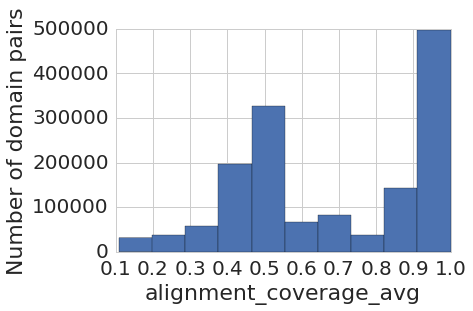

In [772]:
uniprot_pairs_interacting_2['alignment_coverage_avg'].hist()
plt.xlabel('alignment_coverage_avg')
plt.ylabel('Number of domain pairs')

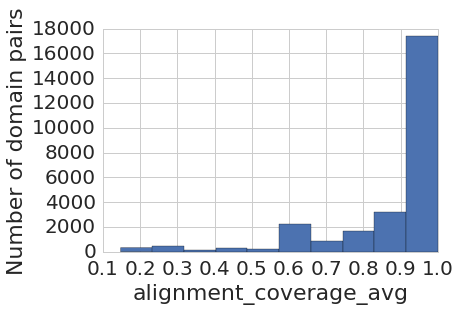

In [773]:
uniprot_pairs_interacting_3f['alignment_coverage_avg'].hist()
plt.xlabel('alignment_coverage_avg')
plt.ylabel('Number of domain pairs')

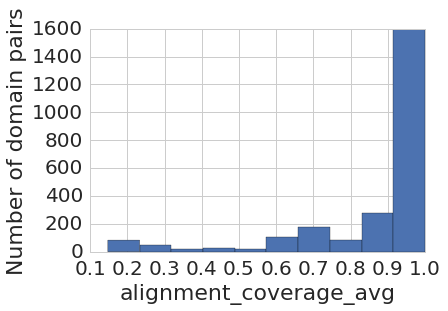

In [774]:
uniprot_pairs_final['alignment_coverage_avg'].hist()
plt.xlabel('alignment_coverage_avg')
plt.ylabel('Number of domain pairs')

### alignment_identity_avg

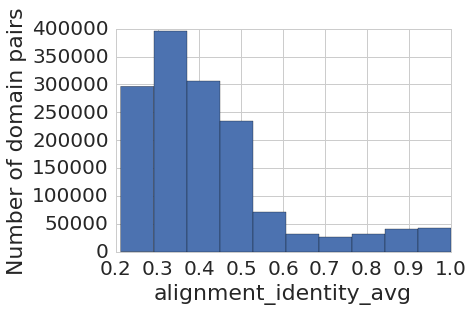

In [775]:
uniprot_pairs_interacting_2['alignment_identity_avg'].hist()
plt.xlabel('alignment_identity_avg')
plt.ylabel('Number of domain pairs')

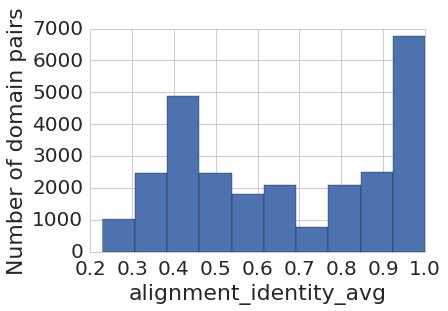

In [776]:
uniprot_pairs_interacting_3f['alignment_identity_avg'].hist()
plt.xlabel('alignment_identity_avg')
plt.ylabel('Number of domain pairs')

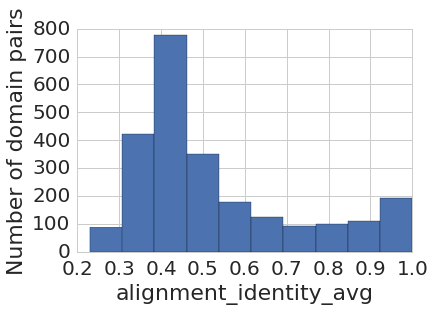

In [777]:
uniprot_pairs_final['alignment_identity_avg'].hist()
plt.xlabel('alignment_identity_avg')
plt.ylabel('Number of domain pairs')

### alignment_score_avg

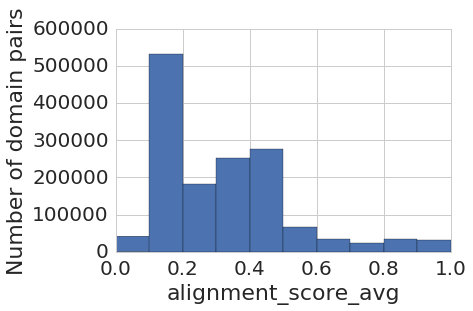

In [778]:
uniprot_pairs_interacting_2['alignment_score_avg'].hist(range=(0, 1))
plt.xlabel('alignment_score_avg')
plt.ylabel('Number of domain pairs')

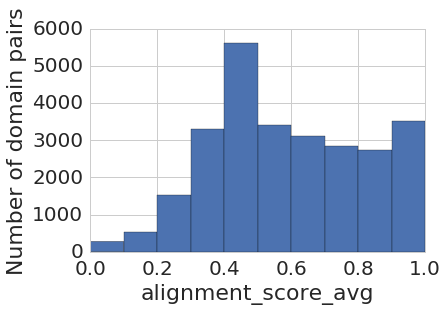

In [779]:
uniprot_pairs_interacting_3f['alignment_score_avg'].hist(range=(0, 1))
plt.xlabel('alignment_score_avg')
plt.ylabel('Number of domain pairs')

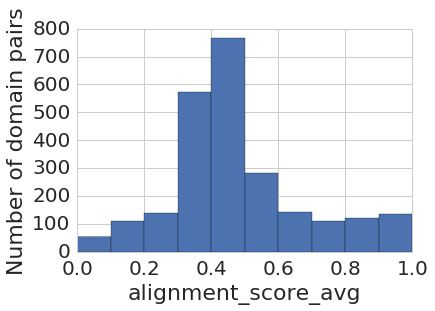

In [780]:
uniprot_pairs_final['alignment_score_avg'].hist(range=(0, 1))
plt.xlabel('alignment_score_avg')
plt.ylabel('Number of domain pairs')

### max_seq_identity

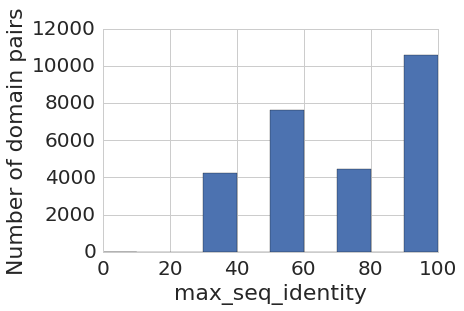

In [782]:
(uniprot_pairs_interacting_3f['max_seq_identity'] - 1).hist(range=(0, 100), bins=10)
plt.xlabel('max_seq_identity')
plt.ylabel('Number of domain pairs')

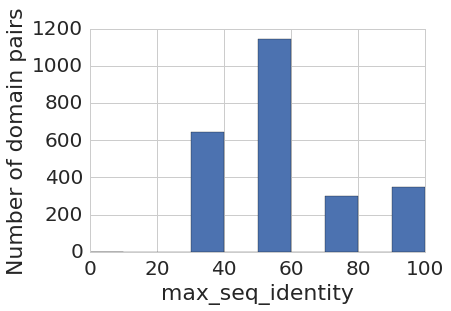

In [783]:
(uniprot_pairs_final['max_seq_identity'] - 1).hist(range=(0, 100), bins=10)
plt.xlabel('max_seq_identity')
plt.ylabel('Number of domain pairs')

## Save to database

### uniprot_domain_pair

In [285]:
uniprot_pairs_final = uniprot_pairs_final_bak.copy()

In [286]:
uniprot_pairs_final['uniprot_domain_pair_id'] = range(1, len(uniprot_pairs_final) + 1)

In [287]:
uniprot_pairs_final['uniprot_id_1'] = uniprot_pairs_final['uniprot_id']
uniprot_pairs_final['uniprot_id_2'] = uniprot_pairs_final['partner_uniprot_id']

In [288]:
# Change the uniprot_id_1, uniprot_id_2 order if it is wrong
uniprot_pairs_final.loc[
    uniprot_pairs_final['uniprot_id'] > uniprot_pairs_final['partner_uniprot_id'],
    'uniprot_id_1'
] = uniprot_pairs_final.loc[
    uniprot_pairs_final['uniprot_id'] > uniprot_pairs_final['partner_uniprot_id'],
    'partner_uniprot_id'
]

uniprot_pairs_final.loc[
    uniprot_pairs_final['uniprot_id'] > uniprot_pairs_final['partner_uniprot_id'],
    'uniprot_id_2'
] = uniprot_pairs_final.loc[
    uniprot_pairs_final['uniprot_id'] > uniprot_pairs_final['partner_uniprot_id'],
    'uniprot_id'
]

In [289]:
uniprot_pairs_final[
    (uniprot_pairs_final['uniprot_domain_id_1'] == 51959162) &
    (uniprot_pairs_final['uniprot_domain_id_2'] == 70394142) & 
    (uniprot_pairs_final['max_seq_identity'] == 80)
]

,uniprot_id,partner_uniprot_id,alignment_coverage_1,alignment_identity_1,alignment_length_1,alignment_score_1,bitscore_1,domain_def_new_1,domain_end_new_1,domain_start_new_1,evalue_1,gap_opens_1,mismatches_1,pc_identity_1,pdb_cath_id_1,pdb_chain_1,pdb_domain_def_1,pdb_id_1,pdb_pdbfam_idx_1,pdb_pdbfam_name_1,pdb_pfam_clan_1,q_end_1,q_start_1,qseq_1,query_id_1,s_end_1,s_start_1,sseq_1,subject_id_1,t_date_modified_1,uniprot_domain_id_1,uniprot_domain_sequence_1,uniprot_sequence_1,a2b_1,b2a_1,alignment_coverage_2,alignment_identity_2,alignment_length_2,alignment_score_2,bitscore_2,domain_def_new_2,domain_end_new_2,domain_start_new_2,evalue_2,gap_opens_2,mismatches_2,pc_identity_2,pdb_cath_id_2,pdb_chain_2,pdb_domain_def_2,pdb_id_2,pdb_pdbfam_idx_2,pdb_pdbfam_name_2,pdb_pfam_clan_2,q_end_2,q_start_2,qseq_2,query_id_2,s_end_2,s_start_2,sseq_2,subject_id_2,t_date_modified_2,uniprot_domain_id_2,uniprot_domain_sequence_2,uniprot_sequence_2,a2b_2,b2a_2,chain_idx_1,residue_idx_1,residue_resname_1,residue_aa_1,chain_idx_2,residue_idx_2,residue_resname_2,residue_aa_2,residue_1_in_domain,residue_2_in_domain,uniprot_mutation,mutation_in_interface,alignment_coverage_avg,alignment_identity_avg,alignment_score_avg,max_seq_identity,uniprot_domain_pair_id,uniprot_id_1,uniprot_id_2
426,A0NA69,P01820,94.174757,95.88,97.0,0.904888,190.0,20:116,116.0,20.0,2.000000e-61,1.0,1.0,95.88,4k2uH00,H,1:212,4k2u,1.0,V-set+C1-set,Ig,97.0,1.0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,unnamed,94.0,1.0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDNYMHWVKQRP---LE...,4k2u_H|V-set+C1-set|1|Ig|1:212|4k2uH00,2016-08-02 10:43:20.429652,51959162,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,MKCSWVIFFLMAVVTGVNSEVQLQQSGAELVKPGASVKLSCTASGF...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",100.0,41.24,97.0,0.44178,87.4,20:115,115.0,20.0,1.000000e-21,1.0,56.0,41.24,4k2uI00,I,1:213,4k2u,1.0,V-set+C1-set,Ig,96.0,1.0,QVQLKESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,unnamed,97.0,1.0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDNYMHWVKQRPEQGLE...,4k2u_I|V-set+C1-set|1|Ig|1:213|4k2uI00,2016-08-02 10:43:23.217894,70394142,QVQLKESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,MAVLALLFCLVTFPSCILSQVQLKESGPGLVAPSQSLSITCTVSGF...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",2,29,30,K,3,74,74,S,True,True,K49A,True,0.970874,0.6856,0.673334,80,3,A0NA69,P01820


In [292]:
# Fill `uniprot_domain_pair` table
sql_command = """\
SET FOREIGN_KEY_CHECKS=0;
TRUNCATE TABLE elaspic_training_interface.uniprot_domain_pair;
SET FOREIGN_KEY_CHECKS=1;
"""
db.engine.execute(sql_command)

columns = [
    c.name for c in elaspic.elaspic_database_tables.UniprotDomainPair.__table__.columns
]
uniprot_domain_pair = (
    uniprot_pairs_final
    [[c for c in columns if c in uniprot_pairs_final.columns or print(c)]]
)

uniprot_domain_pair.to_sql(
    'uniprot_domain_pair', db.engine, schema=NOTEBOOK_NAME, if_exists='append', index=False)

rigids
domain_contact_ids
path_to_data


### uniprot_domain_pair_template

In [293]:
uniprot_pairs_final.head()

,uniprot_id,partner_uniprot_id,alignment_coverage_1,alignment_identity_1,alignment_length_1,alignment_score_1,bitscore_1,domain_def_new_1,domain_end_new_1,domain_start_new_1,evalue_1,gap_opens_1,mismatches_1,pc_identity_1,pdb_cath_id_1,pdb_chain_1,pdb_domain_def_1,pdb_id_1,pdb_pdbfam_idx_1,pdb_pdbfam_name_1,pdb_pfam_clan_1,q_end_1,q_start_1,qseq_1,query_id_1,s_end_1,s_start_1,sseq_1,subject_id_1,t_date_modified_1,uniprot_domain_id_1,uniprot_domain_sequence_1,uniprot_sequence_1,a2b_1,b2a_1,alignment_coverage_2,alignment_identity_2,alignment_length_2,alignment_score_2,bitscore_2,domain_def_new_2,domain_end_new_2,domain_start_new_2,evalue_2,gap_opens_2,mismatches_2,pc_identity_2,pdb_cath_id_2,pdb_chain_2,pdb_domain_def_2,pdb_id_2,pdb_pdbfam_idx_2,pdb_pdbfam_name_2,pdb_pfam_clan_2,q_end_2,q_start_2,qseq_2,query_id_2,s_end_2,s_start_2,sseq_2,subject_id_2,t_date_modified_2,uniprot_domain_id_2,uniprot_domain_sequence_2,uniprot_sequence_2,a2b_2,b2a_2,chain_idx_1,residue_idx_1,residue_resname_1,residue_aa_1,chain_idx_2,residue_idx_2,residue_resname_2,residue_aa_2,residue_1_in_domain,residue_2_in_domain,uniprot_mutation,mutation_in_interface,alignment_coverage_avg,alignment_identity_avg,alignment_score_avg,max_seq_identity,uniprot_domain_pair_id,uniprot_id_1,uniprot_id_2
360036,A0NA69,P01820,93.203883,37.11,97.0,0.375188,46.6,20:115,115.0,20.0,2.000000e-07,4.0,51.0,37.11,4jdvL00,L,1:104,4jdv,1.0,V-set,Ig,96.0,1.0,EVQLQQSGAEL-VKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGL...,unnamed,88.0,1.0,EIVLTQSPATLSLSPGERATLSCRAS--QSVSSYLAWYQQKPGQAP...,4jdv_L|V-set|1|Ig|1:104|4jdvL00,2016-08-02 10:43:20.429652,51959162,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,MKCSWVIFFLMAVVTGVNSEVQLQQSGAELVKPGASVKLSCTASGF...,"1,2,3,4,5,6,7,8,9,10,11,,12,13,14,15,16,17,18,...","1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,2...",98.958333,42.71,96.0,0.450998,92.4,21:115,115.0,21.0,1.000000e-23,1.0,54.0,42.71,4jdvH02,H,2:217,4jdv,1.0,V-set+C1-set,Ig,96.0,2.0,VQLKESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLEW...,unnamed,96.0,1.0,VQLVQSGAEVKKPGASVKVSCKASGYTFTGYYMHWVRQAPGQGLEW...,4jdv_H|V-set+C1-set|1|Ig|2:217|4jdvH02,2016-08-02 10:43:23.217894,70394142,QVQLKESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,MAVLALLFCLVTFPSCILSQVQLKESGPGLVAPSQSLSITCTVSGF...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",3,49,50,D,2,109,103,D,True,True,D71A,True,0.960811,0.39910,0.413093,40,1,A0NA69,P01820
11336,A0NA69,P01820,95.145631,72.45,98.0,0.702436,153.0,20:117,117.0,20.0,5.000000e-47,0.0,27.0,72.45,1xgyI02,I,1:214,1xgy,1.0,V-set+C1-set,Ig,98.0,1.0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,unnamed,98.0,1.0,QVQLQQSGPELVRPGASVKISCKASGYTFTDYYINWVKQRPGQGLE...,1xgy_I|V-set+C1-set|1|Ig|1:214|1xgyI02,2016-08-02 10:43:20.429652,51959162,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,MKCSWVIFFLMAVVTGVNSEVQLQQSGAELVKPGASVKLSCTASGF...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",100.000000,46.39,97.0,0.490705,102.0,20:115,115.0,20.0,4.000000e-27,1.0,51.0,46.39,1xgyH02,H,1:214,1xgy,1.0,V-set+C1-set,Ig,96.0,1.0,QVQLKESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,unnamed,97.0,1.0,QVQLQQSGPELVRPGASVKISCKASGYTFTDYYINWVKQRPGQGLE...,1xgy_H|V-set+C1-set|1|Ig|1:214|1xgyH02,2016-08-02 10:43:23.217894,70394142,QVQLKESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,MAVLALLFCLVTFPSCILSQVQLKESGPGLVAPSQSLSITCTVSGF...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",3,51,52,F,1,118,115,K,True,True,D71A,NaN,0.975728,0.59420,0.596571,60,2,A0NA69,P01820
426,A0NA69,P01820,94.174757,95.88,97.0,0.904888,190.0,20:116,116.0,20.0,2.000000e-61,1.0,1.0,95.88,4k2uH00,H,1:212,4k2u,1.0,V-set+C1-set,Ig,97.0,1.0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,unnamed,94.0,1.0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDNYMHWVKQRP---LE...,4k2u_H|V-set+C1-set|1|Ig|1:212|4k2uH00,2016-08-02 10:43:20.429652,51959162,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLE...,MKCSWVIFFLMAVVTG

In [294]:
uniprot_pairs_final = (
    uniprot_pairs_final
    .rename(
        columns={
            'pdb_cath_id_1': 'cath_id_1',
            'alignment_coverage_1': 'coverage_1',
            'alignment_identity_1': 'identical_1',
            'alignment_score_1': 'score_1',
            
            'pdb_cath_id_2': 'cath_id_2',
            'alignment_coverage_2': 'coverage_2',
            'alignment_identity_2': 'identical_2',
            'alignment_score_2': 'score_2',
        })
)

In [295]:
null_columns = [
    'domain_contact_id', 'template_errors', 't_date_modified', 
    'conserved_1', 'identical_if_1', 'conserved_if_1', 'coverage_if_1', 'score_if_1', 
    'conserved_2', 'identical_if_2', 'conserved_if_2', 'coverage_if_2', 'score_if_2', 
    'score_total', 'score_if_total', 'score_overall'
]
for column in null_columns:
    uniprot_pairs_final[column] = np.nan

In [297]:
# Fill `uniprot_domain_pair` table
sql_command = """\
SET FOREIGN_KEY_CHECKS=0;
TRUNCATE TABLE elaspic_training_interface.uniprot_domain_pair_template;
SET FOREIGN_KEY_CHECKS=1;
"""
db.engine.execute(sql_command)

uniprot_domain_pair_template = (
    uniprot_pairs_final
    [[c.name for c in elaspic.elaspic_database_tables.UniprotDomainPairTemplate.__table__.columns]]
)

uniprot_domain_pair_template.to_sql(
    'uniprot_domain_pair_template', db.engine, schema=NOTEBOOK_NAME, if_exists='append', index=False)

/home/kimlab1/strokach/anaconda/lib/python3.5/site-packages/sqlalchemy/dialects/mysql/mysqldb.py:95: Warning: Column 't_date_modified' cannot be null
  rowcount = cursor.executemany(statement, parameters)


# === Run mutations ===

# Run database mutations

## templates

In [828]:
# uniprot_domain_pair_wtemplate
sql_query = """\
SELECT *
FROM elaspic_training_interface.uniprot_domain_pair
JOIN elaspic_training_interface.uniprot_domain_pair_template USING (uniprot_domain_pair_id)
"""
kmtools.jupyter_tools.print_sql(sql_query)

uniprot_domain_pair_wtemplate = pd.read_sql_query(sql_query, db.engine) 

In [829]:
display(uniprot_domain_pair_wtemplate.head(2))
print(uniprot_domain_pair_wtemplate.shape[0])

,uniprot_domain_pair_id,uniprot_domain_id_1,uniprot_domain_id_2,rigids,domain_contact_ids,path_to_data,uniprot_id_1,uniprot_id_2,max_seq_identity,uniprot_domain_pair_id_old,domain_contact_id,cath_id_1,cath_id_2,identical_1,conserved_1,coverage_1,score_1,identical_if_1,conserved_if_1,coverage_if_1,score_if_1,identical_2,conserved_2,coverage_2,score_2,identical_if_2,conserved_if_2,coverage_if_2,score_if_2,score_total,score_if_total,score_overall,t_date_modified,template_errors
0,1,51959162,70394142,None,None,None,A0NA69,P01820,40,None,None,3eyfA00,3eyfB02,32.99,None,93.2039,0.338708,None,None,None,None,48.45,None,100.0,0.510275,None,None,None,None,None,None,None,None,None
1,2,51959162,70394142,None,None,None,A0NA69,P01820,40,None,None,3w9eB00,3w9eA00,32.99,None,93.2039,0.338708,None,None,None,None,48.45,None,100.0,0.510275,None,None,None,None,None,None,None,None,None


2442


## mutations_wtemplates

In [833]:
DATA_WTEMPLATES = {}

def mutation_in_domain(
        uniprot_id, uniprot_id_1, domain_def_1, uniprot_id_2, domain_def_2, uniprot_mutation):
    if (uniprot_id == uniprot_id_1 and 
            kmtools.sequence_tools.mutation_in_domain(uniprot_mutation, domain_def_1)):
        return True
    if (uniprot_id == uniprot_id_2):
        return kmtools.sequence_tools.mutation_in_domain(uniprot_mutation, domain_def_2)
    raise Exception


dataset_columns = ['uniprot_id', 'partner_uniprot_id', 'uniprot_mutation']

for dataset in DATASETS:
    print(dataset)
    df = DATA[dataset][dataset_columns]
    # df['dataset'] = dataset

    # Remove multi-mutations
    _before = df.shape[0]
    df = df[~df['uniprot_mutation'].str.contains(',')]
    print2("Removed multi-mutants:", _before - df.shape[0])

    print2(
        "Unique interface mutations:", 
        df[['uniprot_id', 'partner_uniprot_id', 'uniprot_mutation']].drop_duplicates().shape[0])

    df_wtemplates = (
        pd.concat([
            df.merge(
                uniprot_domain_pair_wtemplate.rename(
                    columns={'uniprot_id_1': 'uniprot_id', 'uniprot_id_2': 'partner_uniprot_id'}),
                on=['uniprot_id', 'partner_uniprot_id']),
            df.merge(
                uniprot_domain_pair_wtemplate.rename(
                    columns={'uniprot_id_2': 'uniprot_id', 'uniprot_id_1': 'partner_uniprot_id'}),
                on=['uniprot_id', 'partner_uniprot_id']),
        ])
        .drop_duplicates(['uniprot_domain_pair_id'] + dataset_columns)
    )
    print2(
        "Unique interface mutations with templates:", 
        df_wtemplates[['uniprot_id', 'partner_uniprot_id', 'uniprot_mutation']].drop_duplicates().shape[0])

    DATA_WTEMPLATES[dataset] = df_wtemplates

skempi
Removed multi-mutants:                                      463
Unique interface mutations:                                 1750
Unique interface mutations with templates:                  1238
taipale_ppi
Removed multi-mutants:                                      0
Unique interface mutations:                                 2348
Unique interface mutations with templates:                  252
taipale_gpca
Removed multi-mutants:                                      0
Unique interface mutations:                                 742
Unique interface mutations with templates:                  142


In [834]:
mutations_wtemplates = pd.concat(DATA_WTEMPLATES.values(), ignore_index=True)

In [835]:
dataset_columns

['uniprot_id', 'partner_uniprot_id', 'uniprot_mutation']

In [836]:
assert mutations_wtemplates.drop_duplicates().shape[0] == (
    mutations_wtemplates.drop_duplicates(['uniprot_domain_pair_id'] + dataset_columns).shape[0]
)
mutations_wtemplates = mutations_wtemplates.drop_duplicates(['uniprot_domain_pair_id'] + dataset_columns)

In [837]:
display(mutations_wtemplates.head(2))
print(mutations_wtemplates.shape[0])
print(mutations_wtemplates.drop_duplicates().shape[0])
print(mutations_wtemplates.drop_duplicates(['uniprot_domain_pair_id'] + dataset_columns).shape[0])
print(mutations_wtemplates.drop_duplicates(dataset_columns).shape[0])

,uniprot_id,partner_uniprot_id,uniprot_mutation,uniprot_domain_pair_id,uniprot_domain_id_1,uniprot_domain_id_2,rigids,domain_contact_ids,path_to_data,max_seq_identity,uniprot_domain_pair_id_old,domain_contact_id,cath_id_1,cath_id_2,identical_1,conserved_1,coverage_1,score_1,identical_if_1,conserved_if_1,coverage_if_1,score_if_1,identical_2,conserved_2,coverage_2,score_2,identical_if_2,conserved_if_2,coverage_if_2,score_if_2,score_total,score_if_total,score_overall,t_date_modified,template_errors
0,P60709,P60709,R183W,2256,32639633,32639633,None,None,None,60,None,None,3dxkA00,3dxkB00,36.34,None,97.3333,0.384691,None,None,None,None,50.47,None,53.6000,0.283793,None,None,None,None,None,None,None,None,None
1,P60709,P60709,R183W,2257,32639633,32639633,None,None,None,100,None,None,2oanA00,2oanB00,97.27,None,97.6000,0.950687,None,None,None,None,97.30,None,98.9333,0.963957,None,None,None,None,None,None,None,None,None


26337
26337
26337
1490


In [838]:
mutations_wtemplates_bak = mutations_wtemplates.copy()

## qsub

First run with `-t 6` and only UniProt IDs to calculate Provean and domain models.

Next run with `-t 5` and `-i {uniprot_domain_pair_id}` to calculate mutations. 

  - You need to specify `{uniprot_domain_pair_id}` because the pipeline was not designed to work
    with the same domain pairs at different sequence identities.

In [933]:
RUN_NUMBER = 2  # 1: Provean and domain models, 2: Interface models, 3: Mutations
print(RUN_NUMBER)

mutations_wtemplates = mutations_wtemplates_bak.copy()

if RUN_NUMBER == 1:
    system_command_template = """\
    elaspic run \
        --pdb_dir='/home/kimlab1/database_data/pdb/data/data/structures/divided/pdb/' \
        --blast_db_dir='/home/strokach/databases/blast/db' \
        --archive_dir='{archive_dir}' \
        --connection_string='{connection_string}' \
        -vvv \
        -u '{uniprot_id}' \
        -i 0 \
        -t 6 \
        # {uniprot_domain_pair_id} {uniprot_mutations}
    """
    mutations_wtemplates = mutations_wtemplates.drop_duplicates('uniprot_id')

elif RUN_NUMBER == 2:
    system_command_template = """\
    elaspic run \
        --pdb_dir='/home/kimlab1/database_data/pdb/data/data/structures/divided/pdb/' \
        --blast_db_dir='/home/kimlab1/database_data/blast/db' \
        --archive_dir='{archive_dir}' \
        --connection_string='{connection_string}' \
        -vvv \
        -u '{uniprot_id}' \
        -i {uniprot_domain_pair_id} \
        -t 6
        # -m '{uniprot_mutations}' \
    """
    mutations_wtemplates = mutations_wtemplates.drop_duplicates('uniprot_domain_pair_id')

elif RUN_NUMBER == 3:
    system_command_template = """\
    elaspic run \
        --pdb_dir='/home/kimlab1/database_data/pdb/data/data/structures/divided/pdb/' \
        --blast_db_dir='/home/kimlab1/database_data/blast/db' \
        --archive_dir='{archive_dir}' \
        --connection_string='{connection_string}' \
        -vvv \
        -u '{uniprot_id}' \
        -i {uniprot_domain_pair_id} \
        -m '{uniprot_mutations}' \
    """

2


In [934]:
display(mutations_wtemplates.head(2))
print(mutations_wtemplates.shape[0])
print(mutations_wtemplates
      .drop_duplicates(['uniprot_domain_pair_id', 'uniprot_id', 'partner_uniprot_id', 'uniprot_mutation'])
      .shape[0])

,uniprot_id,partner_uniprot_id,uniprot_mutation,uniprot_domain_pair_id,uniprot_domain_id_1,uniprot_domain_id_2,rigids,domain_contact_ids,path_to_data,max_seq_identity,uniprot_domain_pair_id_old,domain_contact_id,cath_id_1,cath_id_2,identical_1,conserved_1,coverage_1,score_1,identical_if_1,conserved_if_1,coverage_if_1,score_if_1,identical_2,conserved_2,coverage_2,score_2,identical_if_2,conserved_if_2,coverage_if_2,score_if_2,score_total,score_if_total,score_overall,t_date_modified,template_errors
0,P60709,P60709,R183W,2256,32639633,32639633,None,None,None,60,None,None,3dxkA00,3dxkB00,36.34,None,97.3333,0.384691,None,None,None,None,50.47,None,53.6000,0.283793,None,None,None,None,None,None,None,None,None
1,P60709,P60709,R183W,2257,32639633,32639633,None,None,None,100,None,None,2oanA00,2oanB00,97.27,None,97.6000,0.950687,None,None,None,None,97.30,None,98.9333,0.963957,None,None,None,None,None,None,None,None,None


2442
2442


In [935]:
%run imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-08-13 21:29:17.741565


In [936]:
logger.setLevel(logging.DEBUG)

In [937]:
logger.debug('xx')

2016-08-13 21:29:18,346 - root - DEBUG - xx


In [938]:
SUFFIX = '_13'
JOB_NAME = 'database_mutations{}'.format(SUFFIX)

mutations_wtemplates['system_command'] = [
    system_command_template
    .format(
        archive_dir=op.abspath(op.join('elaspic_training_interface', 'elaspic')),
        connection_string=mysqld.get_connection_string(db_schema='elaspic_training_interface', db_url=None),
        uniprot_id=uniprot_id,
        uniprot_mutations=uniprot_mutation,
        uniprot_domain_pair_id=uniprot_domain_pair_id
    )
    for uniprot_domain_pair_id, uniprot_id, uniprot_mutation
    in (
        mutations_wtemplates
        [['uniprot_domain_pair_id', 'uniprot_id', 'uniprot_mutation']].values
    )
]

In [939]:
display(mutations_wtemplates.head())
print(mutations_wtemplates.shape[0])

,uniprot_id,partner_uniprot_id,uniprot_mutation,uniprot_domain_pair_id,uniprot_domain_id_1,uniprot_domain_id_2,rigids,domain_contact_ids,path_to_data,max_seq_identity,uniprot_domain_pair_id_old,domain_contact_id,cath_id_1,cath_id_2,identical_1,conserved_1,coverage_1,score_1,identical_if_1,conserved_if_1,coverage_if_1,score_if_1,identical_2,conserved_2,coverage_2,score_2,identical_if_2,conserved_if_2,coverage_if_2,score_if_2,score_total,score_if_total,score_overall,t_date_modified,template_errors,system_command
0,P60709,P60709,R183W,2256,32639633,32639633,None,None,None,60,None,None,3dxkA00,3dxkB00,36.34,None,97.3333,0.384691,None,None,None,None,50.47,None,53.6000,0.283793,None,None,None,None,None,None,None,None,None,elaspic run --pdb_dir='/home/kimla...
1,P60709,P60709,R183W,2257,32639633,32639633,None,None,None,100,None,None,2oanA00,2oanB00,97.27,None,97.6000,0.950687,None,None,None,None,97.30,None,98.9333,0.963957,None,None,None,None,None,None,None,None,None,elaspic run --pdb_dir='/home/kimla...
2,P60709,P60709,R183W,2258,32639633,32639633,None,None,None,100,None,None,3b63F00,3b63E00,94.38,None,94.9333,0.898648,None,None,None,None,94.51,None,97.0667,0.920042,None,None,None,None,None,None,None,None,None,elaspic run --pdb_dir='/home/kimla...
3,P60709,P60709,R183W,2259,32639633,32639633,None,None,None,100,None,None,2gwkB00,2gwkA00,92.93,None,98.1333,0.915422,None,None,None,None,91.85,None,98.1333,0.905354,None,None,None,None,None,None,None,None,None,elaspic run --pdb_dir='/home/kimla...
4,P60709,P60709,R183W,2260,32639633,32639633,None,None,None,100,None,None,4pkhF01,4pkhD01,92.95,None,98.4000,0.918097,None,None,None,None,91.60,None,98.4000,0.905477,None,None,None,None,None,None,None,None,None,elaspic run --pdb_dir='/home/kimla...


2442


In [940]:
!echo {mutations_wtemplates.loc[0, 'system_command']}

elaspic run --pdb_dir=/home/kimlab1/database_data/pdb/data/data/structures/divided/pdb/ --blast_db_dir=/home/kimlab1/database_data/blast/db --archive_dir=/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_training_interface/elaspic --connection_string=mysql://root@192.168.6.210:8309/elaspic_training_interface -vvv -u P60709 -i 2256 -t 6


In [941]:
PATH = (
    '/home/kimlab1/strokach/anaconda/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin'
)

js = jobsubmitter.JobSubmitter(
    JOB_NAME, 'pbs://:@192.168.233.150', op.abspath(NOTEBOOK_NAME),
    email='ostrokach@gmail.com', force_new_folder=False,
    nproc=1, queue='medium', walltime='8:00:00', mem='6G',
    env={'PATH': PATH},
    concurrent_job_limit=800,
)

2016-08-13 21:29:28,956 - jobsubmitter.jobsubmitter - WARNING - Using an existing folder for log output. This is dangerous!!!


In [942]:
js.job_name

'database_mutations_13'

In [931]:
logging.getLogger('jobsubmitter').setLevel(logging.INFO)

In [901]:
with js.connect():
    js.submit(
        mutations_wtemplates.reset_index()[['index', 'system_command']].values.tolist())

2016-08-11 21:08:17,561 - jobsubmitter.jobsubmitter - INFO - 'concurrent_job_limit' reached! Sleeping for 2 minutes...
2016-08-11 21:10:17,784 - jobsubmitter.jobsubmitter - INFO - 'concurrent_job_limit' reached! Sleeping for 2 minutes...
2016-08-11 21:12:17,941 - jobsubmitter.jobsubmitter - INFO - 'concurrent_job_limit' reached! Sleeping for 2 minutes...
2016-08-11 21:14:18,161 - jobsubmitter.jobsubmitter - INFO - 'concurrent_job_limit' reached! Sleeping for 2 minutes...
2016-08-11 21:16:18,385 - jobsubmitter.jobsubmitter - INFO - 'concurrent_job_limit' reached! Sleeping for 2 minutes...
2016-08-11 21:18:18,600 - jobsubmitter.jobsubmitter - INFO - 'concurrent_job_limit' reached! Sleeping for 2 minutes...
2016-08-11 21:20:23,970 - jobsubmitter.jobsubmitter - INFO - 'concurrent_job_limit' reached! Sleeping for 2 minutes...
2016-08-11 21:22:34,563 - jobsubmitter.jobsubmitter - INFO - 'concurrent_job_limit' reached! Sleeping for 2 minutes...
2016-08-11 21:24:40,067 - jobsubmitter.jobsubmit

In [869]:
with js.connect():
    print(js.get_num_running_jobs())

173


### Read results

In [947]:
# Get job status
results_df = (
    js.job_status(mutations_wtemplates.reset_index()[['index', 'system_command']].values.tolist()))
print(Counter(results_df['status']))

Counter({'misformed output': 2440, 'error': 2})


In [ ]:
results_df.head()

In [915]:
mutations_wtemplates.head(2)

,uniprot_id,partner_uniprot_id,uniprot_mutation,uniprot_domain_pair_id,uniprot_domain_id_1,uniprot_domain_id_2,rigids,domain_contact_ids,path_to_data,max_seq_identity,uniprot_domain_pair_id_old,domain_contact_id,cath_id_1,cath_id_2,identical_1,conserved_1,coverage_1,score_1,identical_if_1,conserved_if_1,coverage_if_1,score_if_1,identical_2,conserved_2,coverage_2,score_2,identical_if_2,conserved_if_2,coverage_if_2,score_if_2,score_total,score_if_total,score_overall,t_date_modified,template_errors,system_command
0,P60709,P60709,R183W,2256,32639633,32639633,None,None,None,60,None,None,3dxkA00,3dxkB00,36.34,None,97.3333,0.384691,None,None,None,None,50.47,None,53.6000,0.283793,None,None,None,None,None,None,None,None,None,elaspic run --pdb_dir='/home/kimla...
1,P60709,P60709,R183W,2257,32639633,32639633,None,None,None,100,None,None,2oanA00,2oanB00,97.27,None,97.6000,0.950687,None,None,None,None,97.30,None,98.9333,0.963957,None,None,None,None,None,None,None,None,None,elaspic run --pdb_dir='/home/kimla...


In [916]:
print2("Rows:", mutations_wtemplates.shape[0])
print2("Interface mutations:", mutations_wtemplates.drop_duplicates(
    ['uniprot_domain_pair_id', 'uniprot_id', 'partner_uniprot_id', 'uniprot_mutation']).shape[0])
print2("Mutations:", mutations_wtemplates.drop_duplicates(
    ['uniprot_id', 'partner_uniprot_id', 'uniprot_mutation']).shape[0])

Rows:                                                       26337
Interface mutations:                                        26337
Mutations:                                                  1490


In [589]:
sql_query = """\
SELECT * \
FROM elaspic_training_interface.uniprot_domain_pair_mutation \
"""
mutations_wtemplates_calculated = pd.read_sql_query(sql_query, db.engine)

In [590]:
print2("Rows:", mutations_wtemplates_calculated.shape[0])
print2("Rows with ddg:", mutations_wtemplates_calculated.dropna(subset=['ddg']).shape[0])

Rows:                                                       1893
Rows with ddg:                                              1893


In [597]:
mutations_wtemplates_wresults = (
    mutations_wtemplates
    .merge(mutations_wtemplates_calculated.rename(columns={'mutation': 'uniprot_mutation'})
           [['uniprot_domain_pair_id', 'uniprot_id', 'uniprot_mutation', 'ddg']], 
           on=['uniprot_domain_pair_id', 'uniprot_id', 'uniprot_mutation'],
           how='left',)
)

In [598]:
mutations_wtemplates_wresults.head(2)

,uniprot_id,partner_uniprot_id,uniprot_mutation,uniprot_domain_pair_id,uniprot_domain_id_1,uniprot_domain_id_2,rigids,domain_contact_ids,path_to_data,max_seq_identity,uniprot_domain_pair_id_old,domain_contact_id,cath_id_1,cath_id_2,identical_1,conserved_1,coverage_1,score_1,identical_if_1,conserved_if_1,coverage_if_1,score_if_1,identical_2,conserved_2,coverage_2,score_2,identical_if_2,conserved_if_2,coverage_if_2,score_if_2,score_total,score_if_total,score_overall,t_date_modified,template_errors,system_command,ddg
0,P60709,P60709,R183W,233,32639633,32639633,None,None,training/P60/70/P60709/Actin.3-375/Actin.3-375...,60,None,None,3dxkA00,3dxkB00,36.34,None,97.3333,0.384691,None,None,None,None,50.47,None,53.6000,0.283793,None,None,None,None,None,None,None,None,None,elaspic run --pdb_dir='/home/kimla...,NaN
1,P60709,P60709,R183W,234,32639633,32639633,None,None,training/P60/70/P60709/Actin.3-375/Actin.3-375...,100,None,None,2oanA00,2oanB00,97.27,None,97.6000,0.950687,None,None,None,None,97.30,None,98.9333,0.963957,None,None,None,None,None,None,None,None,None,elaspic run --pdb_dir='/home/kimla...,NaN


In [604]:
print2("Rows:", mutations_wtemplates_wresults.shape[0])
print2("Interface mutations:", mutations_wtemplates_wresults.drop_duplicates(
    ['uniprot_domain_pair_id', 'uniprot_id', 'partner_uniprot_id', 'uniprot_mutation']).shape[0])
print2("Mutations:", mutations_wtemplates_wresults.drop_duplicates(
    ['uniprot_id', 'partner_uniprot_id', 'uniprot_mutation']).shape[0])

print('-' * 80)
print2("Calculated interface mutations:", 
       mutations_wtemplates_wresults
       .drop_duplicates(
            ['uniprot_domain_pair_id', 'uniprot_id', 'partner_uniprot_id', 'uniprot_mutation'])
       .dropna(subset=['ddg'])
       .shape[0])
print2("Calculated mutations:", 
       mutations_wtemplates_wresults
       .drop_duplicates(
            ['uniprot_id', 'partner_uniprot_id', 'uniprot_mutation'])
       .dropna(subset=['ddg'])
       .shape[0])

Rows:                                                       3832
Interface mutations:                                        3832
Mutations:                                                  1490
--------------------------------------------------------------------------------
Calculated interface mutations:                             1893
Calculated mutations:                                       903


In [605]:
mutations_wtemplates_wresults[mutations_wtemplates_wresults['ddg'].isnull()].head()

,uniprot_id,partner_uniprot_id,uniprot_mutation,uniprot_domain_pair_id,uniprot_domain_id_1,uniprot_domain_id_2,rigids,domain_contact_ids,path_to_data,max_seq_identity,uniprot_domain_pair_id_old,domain_contact_id,cath_id_1,cath_id_2,identical_1,conserved_1,coverage_1,score_1,identical_if_1,conserved_if_1,coverage_if_1,score_if_1,identical_2,conserved_2,coverage_2,score_2,identical_if_2,conserved_if_2,coverage_if_2,score_if_2,score_total,score_if_total,score_overall,t_date_modified,template_errors,system_command,ddg
0,P60709,P60709,R183W,233,32639633,32639633,None,None,training/P60/70/P60709/Actin.3-375/Actin.3-375...,60,None,None,3dxkA00,3dxkB00,36.34,None,97.3333,0.384691,None,None,None,None,50.47,None,53.6000,0.283793,None,None,None,None,None,None,None,None,None,elaspic run --pdb_dir='/home/kimla...,NaN
1,P60709,P60709,R183W,234,32639633,32639633,None,None,training/P60/70/P60709/Actin.3-375/Actin.3-375...,100,None,None,2oanA00,2oanB00,97.27,None,97.6000,0.950687,None,None,None,None,97.30,None,98.9333,0.963957,None,None,None,None,None,None,None,None,None,elaspic run --pdb_dir='/home/kimla...,NaN
2,P60709,P60709,E364K,233,32639633,32639633,None,None,training/P60/70/P60709/Actin.3-375/Actin.3-375...,60,None,None,3dxkA00,3dxkB00,36.34,None,97.3333,0.384691,None,None,None,None,50.47,None,53.6000,0.283793,None,None,None,None,None,None,None,None,None,elaspic run --pdb_dir='/home/kimla...,NaN
3,P60709,P60709,E364K,234,32639633,32639633,None,None,training/P60/70/P60709/Actin.3-375/Actin.3-375...,100,None,None,2oanA00,2oanB00,97.27,None,97.6000,0.950687,None,None,None,None,97.30,None,98.9333,0.963957,None,None,None,None,None,None,None,None,None,elaspic run --pdb_dir='/home/kimla...,NaN
4,P60709,Q1KLZ0,R183W,235,32639633,32639638,None,None,training/P60/70/P60709/Actin.3-375/Actin.3-375...,60,None,None,3dxkA00,3dxkB00,36.34,None,97.3333,0.384691,None,None,None,None,50.47,None,53.6000,0.283793,None,None,None,None,None,None,None,None,None,elaspic run --pdb_dir='/home/kimla...,NaN


In [881]:
system_command = (
    mutations_wtemplates_wresults[mutations_wtemplates_wresults['ddg'].isnull()].iloc[0]['system_command']
)
print(system_command)

    elaspic run         --pdb_dir='/home/kimlab1/database_data/pdb/data/data/structures/divided/pdb/'         --blast_db_dir='/home/kimlab1/database_data/blast/db'         --archive_dir='/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_training_interface/elaspic'         --connection_string='mysql://root@192.168.6.210:8309/elaspic_training_interface'         -vvv         -u 'P60709'         -i 233         -m 'R183W'     


### Resubmit failed

In [944]:
# Job statistics
failed = set(results_df[results_df['status'].isin(['error'])]['job_id'])

system_commands_remaining = (
    mutations_wtemplates[
        (mutations_wtemplates.index.isin(failed))
    ]
)
print(len(system_commands_remaining))

2


In [945]:
system_commands_remaining[:10]

,uniprot_id,partner_uniprot_id,uniprot_mutation,uniprot_domain_pair_id,uniprot_domain_id_1,uniprot_domain_id_2,rigids,domain_contact_ids,path_to_data,max_seq_identity,uniprot_domain_pair_id_old,domain_contact_id,cath_id_1,cath_id_2,identical_1,conserved_1,coverage_1,score_1,identical_if_1,conserved_if_1,coverage_if_1,score_if_1,identical_2,conserved_2,coverage_2,score_2,identical_if_2,conserved_if_2,coverage_if_2,score_if_2,score_total,score_if_total,score_overall,t_date_modified,template_errors,system_command
3448,A0NA69,P01820,D71A,81,51959162,70394142,None,None,None,40,None,None,4hg4z00,4hg4Z02,31.96,None,93.2039,0.329588,None,None,None,None,40.21,None,100.0000,0.431995,None,None,None,None,None,None,None,None,None,elaspic run --pdb_dir='/home/kimla...
3785,A0NA69,P01820,D71A,1018,70394142,51959162,None,None,None,40,None,None,4hg4Z02,4hg4z00,40.21,None,100.0000,0.431995,None,None,None,None,31.96,None,93.2039,0.329588,None,None,None,None,None,None,None,None,None,elaspic run --pdb_dir='/home/kimla...


In [952]:
!{system_commands_remaining.loc[3448, 'system_command']}

Creating 'provean_temp_dir' folder: /tmp/strokach/elaspic/2evhann4/sequence/provean_temp...
Creating 'temp_dir' folder: /tmp/strokach/elaspic...
Creating 'sequence_dir' folder: /tmp/strokach/elaspic/2evhann4/sequence...
Creating 'modeller_dir' folder: /tmp/strokach/elaspic/2evhann4/model/modeller...
Creating 'unique_temp_dir' folder: /tmp/strokach/elaspic/2evhann4...
Creating 'archive_temp_dir' folder: /tmp/strokach/elaspic/archive...
Creating 'model_dir' folder: /tmp/strokach/elaspic/2evhann4/model...
Creating 'pdb_dir' folder: /home/kimlab1/database_data/pdb/data/data/structures/divided/pdb/...
Creating 'blast_db_dir' folder: /home/kimlab1/database_data/blast/db...
Creating 'data_dir' folder: /home/kimlab1/strokach/working/elaspic/elaspic/data...
Creating 'archive_dir' folder: /home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_training_interface/elaspic...
Creating 'tcoffee_dir' folder: /tmp/strokach/elaspic/2evhann4/model/tcoffee...
uniprot_domain_pair_

In [946]:
with js.connect():
    js.submit(system_commands_remaining.reset_index()[['index', 'system_command']].values.tolist())